In [1]:
import os
import sys
sys.path.append('/home/el2522/.local/lib/python3.8/site-packages')
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV

pd.set_option('display.max_columns', None)

import random
import itertools
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import scipy.stats as stats
from scipy.stats import mannwhitneyu, ttest_ind, chi2_contingency, fisher_exact, shapiro
import statsmodels.api as sm
import pickle
np.random.seed(66)
sys.path.append('/data/master/DS217/users/el2522')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [1]:
import os
import sys
sys.path.append('/home/el2522/.local/lib/python3.8/site-packages')
sys.path.append('/data/master/DS217/users/el2522')

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torchtuples as tt

np.random.seed(1234)
_ = torch.manual_seed(123)

In [2]:
# Load the data
data_dir = '/data/master/DS217/users/el2522/'
file_path = os.path.join(data_dir, 'ventDataPrep/intermediate/df_validated.pkl')
df = pd.read_pickle(file_path)

In [3]:
# Open the file for reading
data_dir = '/data/master/DS217/users/el2522/'
file_path = os.path.join(data_dir, 'EF_test_data_record.pkl')

with open(file_path, 'rb') as file:
    EF_data = pickle.load(file)

EF_id_list = EF_data['encounterId']


## Feature Engineering

In [4]:
df.columns

Index(['encounterId', 'utcChartTime', 'gender', 'weight', 'hospital', 'PIM',
       'MAP', 'TV(measured)', 'RR(measured)', 'etCO2', 'temp', 'HR', 'SpO2',
       'systolicBP', 'meanBP', 'diastolicBP', 'pH', 'PCO2', 'baseExcess',
       'lactate', 'HCO3', 'WBC', 'Neutrophil', 'Hb', 'fluidBalance', 'NMB',
       'sedation', 'furosemide', 'vasoActive', 'steroid', 'FiO2', 'PIP',
       'RR(set)', 'PEEP(set)', 'inspTime', 'PS+PEEP', 'ifDeceased', 'LOV',
       'LOS', 'timestamp', 'age_group', 'ventMode_NIV', 'ventMode_NoSupport',
       'ventMode_PC', 'ventMode_PS', 'airwayStatus_Extubated',
       'airwayStatus_Intubated', 'airwayStatus_TubeKeptIn',
       'airwayStatus_TubeKeptOut', 'SFRatio', 'PS', 'TVbyWeight', 'RRRatio',
       'IERatio', 'deltaP', 'mPower', 'diagnosis', 'ethnicity'],
      dtype='object')

In [5]:
df = pd.get_dummies(df, columns=['diagnosis', 'ethnicity'])

In [6]:
# define vars
demo_cols = ['gender','age_group', 'weight', 'PIM'] + [x for x in df.columns if 
                                            x.startswith(('ethnicity', 'diagnosis'))]

age_dependent_cols = ['HR', 'systolicBP', 'meanBP', 'diastolicBP']

categoric_cols = ['NMB', 'sedation', 'furosemide', 'vasoActive', 'steroid', 'ventMode_PC', 'ventMode_PS']

numerical_cols = ['timestamp', 'MAP','RR(measured)', 'etCO2', 'temp', 'HR', 'SpO2',
       'systolicBP', 'meanBP', 'diastolicBP', 'pH', 'PCO2', 'baseExcess',
       'lactate', 'HCO3', 'WBC', 'Neutrophil', 'Hb', 'fluidBalance', 'FiO2', 'PIP',
       'RR(set)', 'PEEP(set)', 'inspTime', 'PS', 'TVbyWeight', 'RRRatio',
       'IERatio', 'deltaP', 'mPower', 'SFRatio']

physio_measure = ['timestamp', 'gender', 'age_group', 'weight', 'RR(measured)', 'temp', 'HR', 'SpO2', 'systolicBP',
       'meanBP', 'diastolicBP', 'pH', 'PCO2', 'baseExcess', 'lactate', 'HCO3', 'WBC',
       'Neutrophil', 'Hb', 'fluidBalance']

In [7]:
# Convert data type
for col in categoric_cols+['gender','age_group']+[x for x in df.columns if 
                                            x.startswith(('ethnicity', 'diagnosis'))]:
    df[col] = df[col].astype('int')

# Round the timestamp to the nearest whole number and then convert to int
df[['timestamp', 'LOV']] = np.round(df[['timestamp', 'LOV']]).astype(int)
    
# Identify the timestep of the first instance of NIV or NoSupport for each encounterId:
first_extubation_time = df.groupby('encounterId').apply(
    lambda group: group[(group['airwayStatus_Extubated'] == 1)]['timestamp'].min() 
                  if not group[(group['airwayStatus_Extubated'] == 1)]['timestamp'].empty 
                  else group['timestamp'].iloc[-1]
)
df['first_extubation_time'] = df['encounterId'].map(first_extubation_time)

print('LOV is less than 6 hours:', df.groupby('encounterId').filter(lambda x: x.LOV.iloc[0]<=6).encounterId.nunique())
df = df.groupby('encounterId').filter(lambda x: x.LOV.iloc[0]>6)


LOV is less than 6 hours: 604


In [8]:
def compute_outcomes_with_censoring(group):
    group.set_index('timestamp', inplace=True)
    
    # Identify the timestep of the first instance of NIV or NoSupport for each encounterId:
    vent_start = group[group.airwayStatus_Intubated==1].first_valid_index()
    vent_end = group[group.airwayStatus_Extubated==1].last_valid_index()
    
    # Censoring indicator
    # It's event (0) if we don't have a complete 48-hour observation window post-extubation,

    if (vent_end is None) | (group[['airwayStatus_Intubated', 'airwayStatus_TubeKeptIn']].iloc[-1].sum()!=0):
        if group['ifDeceased'].iloc[0]==1:
            event_description = 'Not Extubated - Deceased'
        else:
            event_description = 'Not Extubated - Alive'
    elif (group['airwayStatus_TubeKeptOut'].iloc[-48:].sum()!=48):
        if group['ifDeceased'].iloc[0]==1:
            event_description = 'No 48h Observation - Deceased'
        else:
            event_description = f'No 48h Observation - Alive'
    elif group['airwayStatus_TubeKeptOut'].iloc[-48:].sum()==48:
        event_description = "Successful Extubation"
        
    num_intub = group.airwayStatus_Intubated.sum()

    return pd.Series({
        'vent_start_time': int(vent_start),
        'vent_end_time': int(vent_end) if not event_description.startswith('Not Extubated') else int(group.index[-1]),
        'num_intub': int(num_intub),
        'event_description': event_description,
    })

# Apply function and merge results
vent_outcome = df.groupby('encounterId').apply(compute_outcomes_with_censoring).reset_index()
df = df.merge(vent_outcome, on='encounterId', how='left')


In [9]:
vent_outcome.groupby('num_intub').event_description.value_counts()

num_intub  event_description            
1          No 48h Observation - Alive       2259
           Successful Extubation            1746
           Not Extubated - Alive             276
           Not Extubated - Deceased          116
           No 48h Observation - Deceased      15
2          Successful Extubation             197
           No 48h Observation - Alive         96
           Not Extubated - Alive              13
           Not Extubated - Deceased            8
           No 48h Observation - Deceased       2
3          Successful Extubation              22
           No 48h Observation - Alive          8
           Not Extubated - Deceased            2
4          Successful Extubation               6
           No 48h Observation - Alive          1
           Not Extubated - Alive               1
           Not Extubated - Deceased            1
Name: count, dtype: int64

In [10]:
df_pred = df.copy()
df_pred['time_to_event'] = df_pred.groupby('encounterId').apply(
    lambda x: (x.timestamp.max()-x.timestamp).astype(int)).reset_index(drop=True)
df_pred['time_to_final_weaning'] = (df_pred.vent_end_time-df_pred.timestamp).astype(int)
df_pred['extubation_ready'] = (df_pred['time_to_final_weaning'] <= 24).astype(int) 
df_pred = df_pred[(df_pred.timestamp > df_pred.vent_start_time)]
df_pred = df_pred[(df_pred.time_to_final_weaning<=24*28)]


df_ef = df_pred[df_pred.encounterId.isin(EF_id_list)]
df_ef['encounterId_ordered'] = pd.Categorical(df_ef['encounterId'], categories=EF_id_list, ordered=True)
df_ef = df_ef.sort_values('encounterId_ordered')
df_ef.drop('encounterId_ordered', axis=1, inplace=True)  # Optional: drop the helper column

df_pred_without_failure = df_pred[(~df_pred.encounterId.isin(EF_id_list)) & 
                                  (df_pred.num_intub==1) & (~df_pred.event_description.str.contains('Deceased'))]
df_pred_with_failure = df_pred[(~df_pred.encounterId.isin(EF_id_list)) & 
                               (df_pred.num_intub>1)|(df_pred.event_description.str.contains('Deceased'))]

/tmp/ipykernel_705964/3972639657.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ef['encounterId_ordered'] = pd.Categorical(df_ef['encounterId'], categories=EF_id_list, ordered=True)


### Data Prep for Time-to-event Prediction

In [11]:
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [12]:
# aggregate previous observations
df_pred_without_failure['timestamp_original'] = df_pred_without_failure['timestamp']
df_pred_without_failure['event'] = df_pred_without_failure['event_description'].apply(
    lambda x: False if x == "Not Extubated - Alive" else True)


/tmp/ipykernel_705964/2745653439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_without_failure['timestamp_original'] = df_pred_without_failure['timestamp']
/tmp/ipykernel_705964/2745653439.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_without_failure['event'] = df_pred_without_failure['event_description'].apply(


In [13]:

df_baseline = df_pred_without_failure.loc[df_pred_without_failure.time_to_final_weaning>0].copy()
# df_baseline = df_baseline.groupby('encounterId').apply(lambda x: x.iloc[0])

# Get unique encounterIds
id_df = df_baseline[['encounterId', 'event_description']].drop_duplicates()

# Split the unique encounterIds into train and test sets
id_df_train_val, id_df_test = train_test_split(id_df, stratify = id_df['event_description'],
                                               test_size=0.2)
id_df_train, id_df_val = train_test_split(id_df_train_val, stratify = id_df_train_val['event_description'],
                                               test_size=0.2)

# Filter the original dataframe based on the splits of encounterIds
df_train = df_baseline[df_baseline['encounterId'].isin(id_df_train['encounterId'])]
df_val = df_baseline[df_baseline['encounterId'].isin(id_df_val['encounterId'])]
df_test = df_baseline[df_baseline['encounterId'].isin(id_df_test['encounterId'])]

# # Ensure that the maximum time_to_final_weaning in the test set is less than in the train set
# max_train_time = df_train['time_to_final_weaning'].max()
# df_test = df_test[df_test['time_to_final_weaning'] < max_train_time]

# Prepare the features for model fitting
X_train = df_train[demo_cols + categoric_cols + numerical_cols]
X_val = df_val[demo_cols + categoric_cols + numerical_cols]
X_test = df_test[demo_cols + categoric_cols + numerical_cols]

# Standardization for other numerical columns
scaler = MinMaxScaler()
cols_to_transform = X_train.columns
X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
X_val[cols_to_transform] = scaler.transform(X_val[cols_to_transform]) 
X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform]) # Apply same transformation to test data

X_train = X_train.values.astype('float32')
X_val = X_val.values.astype('float32')
X_test = X_test.values.astype('float32')

/tmp/ipykernel_705964/1701762272.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
/tmp/ipykernel_705964/1701762272.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[cols_to_transform] = scaler.transform(X_val[cols_to_transform])
/tmp/ipykernel_705964/1701762272.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [14]:

# Given your split, now let's create the structures for the survival analysis
def get_target(df, duration_col, event_col):
    return (df[duration_col].values, df[event_col].values.astype('float32'))
y_train = get_target(df_train, 'time_to_final_weaning', 'event')
y_val = get_target(df_val, 'time_to_final_weaning', 'event')
train = (X_train, y_train)
val = (X_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test, 'time_to_final_weaning', 'event')

In [55]:
in_features = X_train.shape[1]
out_features = y_train[0].max()+1
batch_norm = True
dropout = 0.3

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 64),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(64),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, out_features)
)

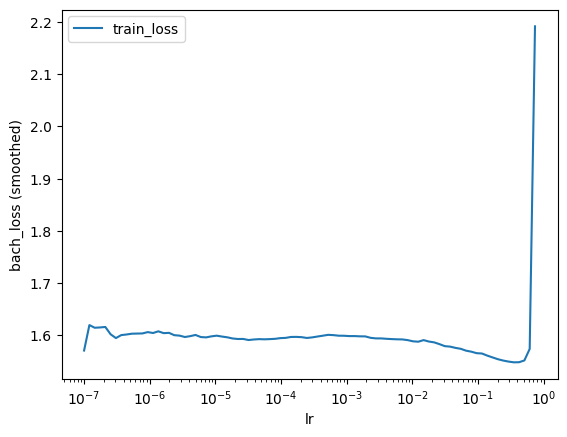

In [56]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1)
batch_size = 256
lr_finder = model.lr_finder(X_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [57]:
lr_finder.get_best_lr()

0.035111917342150994

In [58]:
model.optimizer.set_lr(0.01)

In [59]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(X_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[30s / 30s],		train_loss: 1.3230,	val_loss: 1.3108
1:	[29s / 1m:0s],		train_loss: 1.2911,	val_loss: 1.3143
2:	[29s / 1m:29s],		train_loss: 1.2844,	val_loss: 1.3193
3:	[30s / 2m:0s],		train_loss: 1.2859,	val_loss: 1.3224
4:	[30s / 2m:31s],		train_loss: 1.2785,	val_loss: 1.3188
5:	[30s / 3m:2s],		train_loss: 1.2822,	val_loss: 1.3175
6:	[31s / 3m:33s],		train_loss: 1.2744,	val_loss: 1.3224
7:	[31s / 4m:5s],		train_loss: 1.2738,	val_loss: 1.3378
8:	[30s / 4m:35s],		train_loss: 1.2691,	val_loss: 1.3280
9:	[29s / 5m:5s],		train_loss: 1.2652,	val_loss: 1.3401
10:	[29s / 5m:35s],		train_loss: 1.2635,	val_loss: 1.3407


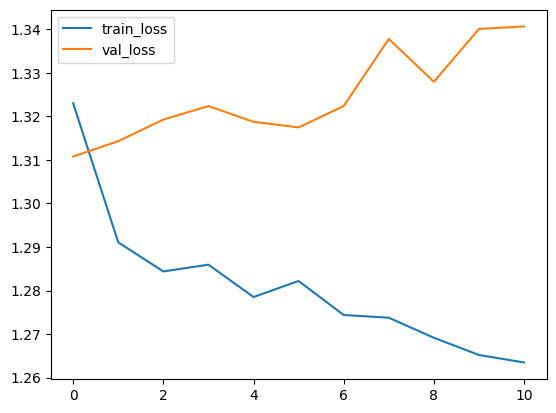

In [60]:
_ = log.plot()

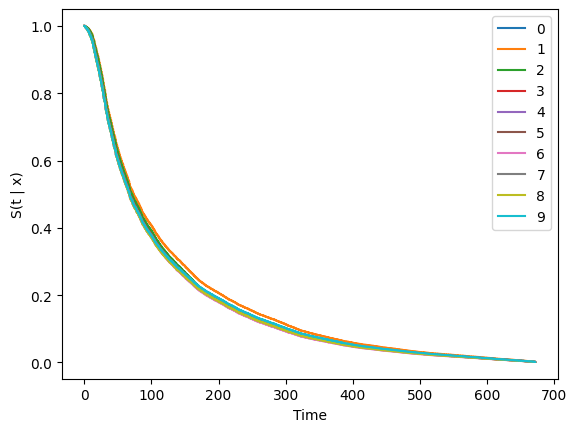

In [61]:
surv = model.predict_surv_df(X_test)
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [62]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

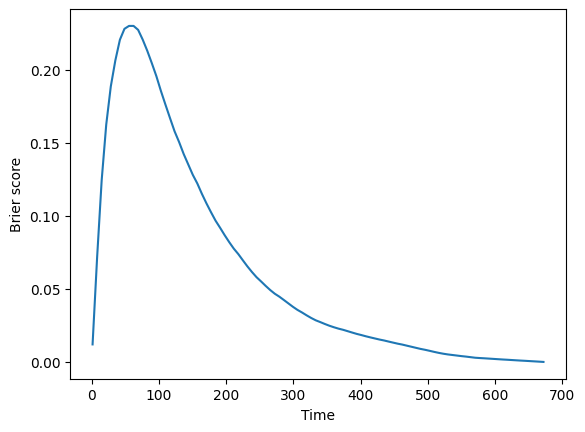

In [63]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [64]:

def median_survival_times(surv_df):
    """Calculate the median survival times from survival functions where rows are times and columns are individuals."""
    def find_median_time(surv_series):
        below_half = surv_series[surv_series < 0.5]
        if not below_half.empty:
            return below_half.index[0]
        return surv_series.index[-1]  # Return the last time if the survival never drops below 0.5

    med_times = surv_df.apply(find_median_time, axis=0)  # Apply to each column (individual)
    return med_times


def compute_mae(pred_med_times, actual_durations, event_indicators):
    """Compute MAE for uncensored observations."""
    # Filter to only uncensored data
    uncensored_indices = event_indicators == 1
    actual_times = actual_durations[uncensored_indices]
    pred_times = pred_med_times[uncensored_indices]
    mae = np.mean(np.abs(pred_times - actual_times))
    return mae


def compute_rmse(pred_med_times, actual_durations, event_indicators):
    """Compute RMSE for uncensored observations."""
    # Filter to only uncensored data
    uncensored_indices = event_indicators == 1
    actual_times = actual_durations[uncensored_indices]
    pred_times = pred_med_times[uncensored_indices]
    rmse = np.sqrt(np.mean((pred_times - actual_times) ** 2))
    return rmse


def compute_mape(pred_med_times, actual_durations, event_indicators):
    """Compute MAPE for uncensored observations."""
    # Filter to only uncensored data
    uncensored_indices = event_indicators == 1
    actual_times = actual_durations[uncensored_indices]
    pred_times = pred_med_times[uncensored_indices]
    # Avoid division by zero
    actual_times = actual_times[actual_times != 0]
    pred_times = pred_times[:len(actual_times)]
    mape = np.mean(np.abs((pred_times - actual_times) / actual_times)) * 100
    return mape

predicted_median_times = median_survival_times(surv)
mae = compute_mae(predicted_median_times, durations_test, events_test)
rmse = compute_rmse(predicted_median_times, durations_test, events_test)
mape = compute_mape(predicted_median_times, durations_test, events_test)


In [65]:
time_grid = np.arange(durations_test.min(), durations_test.max()+1, step=1)

# Compute evaluation metrics
c_index = ev.concordance_td()  # Calculate the concordance index
brier_score = ev.brier_score(np.array([24])).values[0]  # Calculate the Brier score at a specific time point
integrated_brier_score = ev.integrated_brier_score(time_grid)  # Calculate the integrated Brier score

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Model': ['DeepHit'],
    'C-Index': [c_index],
    'Brier Score': [brier_score],
    'Integrated Brier Score': [integrated_brier_score],
    'MAE': [mae],
    'RMSE': [rmse],
    'MAPE (%)': [mape]
})

metrics_df

,Model,C-Index,Brier Score,Integrated Brier Score,MAE,RMSE,MAPE (%)
0,DeepHit,0.72291,0.175028,0.062622,52.469025,84.698259,274.38412


In [12]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.functions import StepFunction
from sksurv.metrics import (
    concordance_index_censored as c_index,
    cumulative_dynamic_auc,
    integrated_brier_score,
    as_integrated_brier_score_scorer
)
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.utils import resample
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter


In [13]:
# aggregate previous observations
df_pred_without_failure['timestamp_original'] = df_pred_without_failure['timestamp']
df_pred_without_failure['event'] = df_pred_without_failure['event_description'].apply(
    lambda x: False if x == "Not Extubated - Alive" else True)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# Given your split, now let's create the structures for the survival analysis
def create_survival_data(df, event_col, duration_col):
    return Surv.from_dataframe(event=event_col, time=duration_col, data=df)

df_baseline = df_pred_without_failure.loc[df_pred_without_failure.time_to_final_weaning>0].copy()
# df_baseline = df_baseline.groupby('encounterId').apply(lambda x: x.iloc[0])

# Get unique encounterIds
id_df = df_baseline[['encounterId', 'event_description']].drop_duplicates()

# Split the unique encounterIds into train and test sets
id_list_train, id_list_test = train_test_split(id_df['encounterId'], stratify = id_df['event_description'],
                                               test_size=0.2, random_state=42)

# Filter the original dataframe based on the splits of encounterIds
df_train = df_baseline[df_baseline['encounterId'].isin(id_list_train)]
df_test = df_baseline[df_baseline['encounterId'].isin(id_list_test)]

# Ensure that the maximum time_to_final_weaning in the test set is less than in the train set
max_train_time = df_train['time_to_final_weaning'].max()
df_test = df_test[df_test['time_to_final_weaning'] < max_train_time]

# Prepare the features for model fitting
X_train = df_train[demo_cols + categoric_cols + numerical_cols]
X_test = df_test[demo_cols + categoric_cols + numerical_cols]

# Prepare survival data for fitting the models
y_train_surv = create_survival_data(df_train, 'event', 'time_to_final_weaning')
y_test_surv = create_survival_data(df_test, 'event', 'time_to_final_weaning')

# Standardization for other numerical columns
scaler = MinMaxScaler()
cols_to_transform = X_train.columns
X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])  # Apply same transformation to test data

time_steps = np.arange(df_test['time_to_final_weaning'].min(), df_test['time_to_final_weaning'].max(), step=1) # for plots later



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
y_events = df_train[df_train["event"]]
train_min, train_max = df_train["time_to_final_weaning"].min(), df_train["time_to_final_weaning"].max()

y_events = df_test[df_test["event"]]
test_min, test_max = y_events["time_to_final_weaning"].min(), y_events["time_to_final_weaning"].max()

assert (
    train_min <= test_min < test_max < train_max
), "time range or test data is not within time range of training data."

In [16]:
subsampling_fraction = .3
X_train_subsample, y_train_surv_subsample = resample(X_train, y_train_surv,
                                                     n_samples=int(X_train.shape[0] * subsampling_fraction),
                                                     random_state=42, stratify=y_train_surv['event'])

# refine time steps to take consideration, taking a conservative approach
lower, upper = np.percentile(y_train_surv_subsample['time_to_final_weaning'], [0, 90])
time_steps_tmp = np.arange(lower, upper + 1, step=4)

# Define cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# CoxPH Grid Search
param_grid_cox = {
    'estimator__alpha': [0.001, 0.01, 0.1, 1, 10]  # Regularization strengths
}

# Setup GridSearchCV with the Integrated Brier Score scorer
grid_search_cox = GridSearchCV(
    as_integrated_brier_score_scorer(CoxPHSurvivalAnalysis(), times=time_steps_tmp),
    param_grid=param_grid_cox,
    cv=cv,
    n_jobs=16,
    error_score='raise'
).fit(X_train_subsample, y_train_surv_subsample)

# RSF Model grid search setup with Integrated Brier Score
param_grid_rsf = {
    'estimator__n_estimators': [100, 200],
    'estimator__min_samples_leaf': [5, 15, 50, 100],
    'estimator__max_features': [None, 'sqrt', 'log2'],
    'estimator__max_depth': [None, 10, 20, 30]  
}

# Setup GridSearchCV with the Integrated Brier Score scorer
grid_search_rsf = GridSearchCV(
    as_integrated_brier_score_scorer(RandomSurvivalForest(random_state=42), times=time_steps_tmp),
    param_grid=param_grid_rsf,
    cv=cv,
    n_jobs=16,
    error_score='raise'
).fit(X_train_subsample, y_train_surv_subsample)

# Results
print("Best parameters for CoxPH:", grid_search_cox.best_params_)
print("Best score for CoxPH:", grid_search_cox.best_score_)
print("Best parameters for RSF:", grid_search_rsf.best_params_)
print("Best score for RSF:", grid_search_rsf.best_score_)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best parameters for CoxPH: {'estimator__alpha': 0.001}
Best score for CoxPH: -0.1365952430442757
Best parameters for RSF: {'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 5, 'estimator__n_estimators': 200}
Best score for RSF: -0.04830107985460082


In [17]:

# Extract best parameters and remove the 'estimator__' prefix
best_params_cox = {k.replace('estimator__', ''): v for k, v in grid_search_cox.best_params_.items()}
best_params_rsf = {k.replace('estimator__', ''): v for k, v in grid_search_rsf.best_params_.items()}

# Initialize the CoxPH model with a penalizer term to help with potential multicollinearity
cph_model = CoxPHSurvivalAnalysis(**best_params_cox)
cph_model.fit(X_train, y_train_surv)

# Define the fraction of the data you want to keep. For example, 0.1 for 10%
subsampling_fraction = 1.

# Perform subsampling
X_train_subsample, y_train_surv_subsample = resample(X_train, y_train_surv, 
                                                     n_samples=int(X_train.shape[0] * subsampling_fraction), 
                                                     random_state=42, stratify=y_train_surv['event'])

rsf_model = RandomSurvivalForest(**best_params_rsf, random_state=42, n_jobs=8)
rsf_model.fit(X_train_subsample, y_train_surv_subsample)



RandomSurvivalForest(max_features=None, min_samples_leaf=5, n_estimators=200,
                     n_jobs=8, random_state=42)

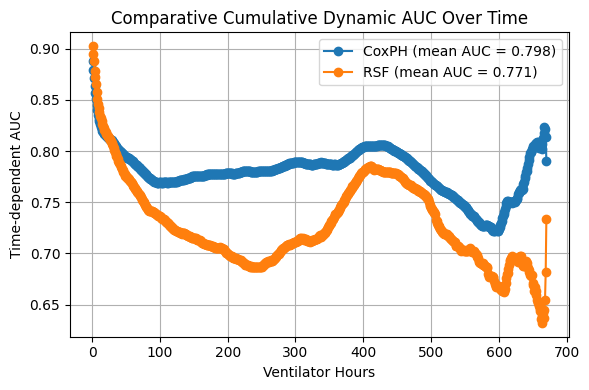

In [18]:

cph_risk_scores = cph_model.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, cph_risk_scores, time_steps)

rsf_chf_funcs = rsf_model.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(time_steps) for chf in rsf_chf_funcs])
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_risk_scores, time_steps)

# Visualization
plt.figure(figsize=(6, 4))
plt.plot(time_steps, cph_auc, "o-", label=f"CoxPH (mean AUC = {cph_mean_auc:.3f})")
plt.plot(time_steps, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("Ventilator Hours")
plt.ylabel("Time-dependent AUC")
plt.title("Comparative Cumulative Dynamic AUC Over Time")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:


# Existing data setup
cph_risk_scores = cph_model.predict(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, cph_risk_scores, time_steps)

rsf_chf_funcs = rsf_model.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(time_steps) for chf in rsf_chf_funcs])
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train_surv, y_test_surv, rsf_risk_scores, time_steps)

# Calculate number at risk at each time step
# This is a placeholder calculation - replace it with your actual method to compute 'at_risk'
at_risk = np.array([np.sum(y_test_surv["time_to_final_weaning"] >= t) for t in time_steps])

# Visualization
plt.figure(figsize=(10, 6))
ax1 = plt.gca()  # Get current axis
ax2 = ax1.twinx()  # Create another axis that shares the same x-axis

# Plotting the AUC curves on primary y-axis
ax1.plot(time_steps, cph_auc, "o-", label=f"CoxPH (mean AUC = {cph_mean_auc:.3f})")
ax1.plot(time_steps, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
ax1.set_xlabel("Ventilator Hours")
ax1.set_ylabel("Time-dependent AUC")
ax1.legend(loc="upper left")
ax1.grid(True)

# Plotting the number at risk on secondary y-axis
ax2.plot(time_steps, at_risk, "s-", color='gray', alpha=0.7, label="Number at risk")
ax2.set_ylabel("Number at risk")
ax2.legend(loc="upper right")

plt.title("Comparative Cumulative Dynamic AUC and Number at Risk Over Time")
plt.tight_layout()
plt.show()


In [19]:
score_cindex = pd.Series(
    [
        rsf_model.score(X_test, y_test_surv),
        cph_model.score(X_test, y_test_surv),
        0.5,
    ],
    index=["RSF", "CPH", "Random"],
    name="c-index",
)

score_cindex.round(3)

RSF       0.664
CPH       0.712
Random    0.500
Name: c-index, dtype: float64

In [20]:
rsf_surv_prob = np.row_stack([fn(time_steps) for fn in rsf_model.predict_survival_function(X_test)])
cph_surv_prob = np.row_stack([fn(time_steps) for fn in cph_model.predict_survival_function(X_test)])
random_surv_prob = 0.5 * np.ones((y_test_surv.shape[0], time_steps.shape[0]))
km_func = StepFunction(*kaplan_meier_estimator(y_test_surv["event"], y_test_surv["time_to_final_weaning"]))
km_surv_prob = np.tile(km_func(time_steps), (y_test_surv.shape[0], 1))

score_brier = pd.Series(
    [
        integrated_brier_score(y_train_surv, y_test_surv, prob, time_steps)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
RSF,0.664,0.081
CPH,0.712,0.074
Random,0.500,0.251
Kaplan-Meier,NaN,0.088


In [294]:
[x for x in range(150) if y_test_surv[x]['time_to_final_weaning']>100]

[3,
 6,
 14,
 24,
 30,
 31,
 34,
 37,
 42,
 45,
 52,
 54,
 56,
 65,
 67,
 70,
 73,
 74,
 75,
 76,
 77,
 79,
 81,
 85,
 86,
 87,
 93,
 94,
 98,
 101,
 103,
 106,
 107,
 109,
 110,
 113,
 114,
 115,
 116,
 120,
 124,
 126,
 130,
 136,
 139,
 140,
 145,
 146,
 147]

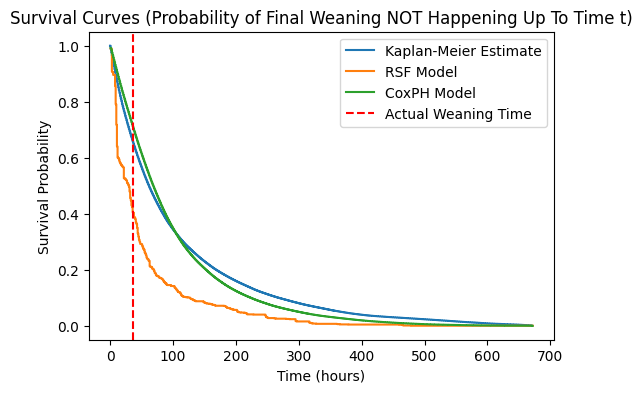

In [21]:

individual_index = 110

# Placeholder for actual weaning time for the patient we want to plot
actual_weaning_time = y_test_surv[[individual_index]]['time_to_final_weaning']

# Predicting the survival function for the selected patient from RSF and CoxPH
rsf_survival_function = rsf_model.predict_survival_function(X_test.iloc[[individual_index]])[0]
cph_survival_function = cph_model.predict_survival_function(X_test.iloc[[individual_index]])[0]

# Plotting the survival curves for the RSF and CoxPH models
plt.figure(figsize=(6, 4))

# Kaplan-Meier Survival Estimate
kmf = KaplanMeierFitter()
kmf.fit(y_test_surv['time_to_final_weaning'], event_observed=y_test_surv['event'])
plt.step(kmf.event_table.index, kmf.survival_function_, where="post", label='Kaplan-Meier Estimate')

# RSF Survival Function
plt.step(rsf_survival_function.x, rsf_survival_function(rsf_survival_function.x), where="post", label='RSF Model')

# CoxPH Survival Function
plt.step(cph_survival_function.x, cph_survival_function(cph_survival_function.x), where="post", label='CoxPH Model')

# Adding a vertical line for the actual weaning time
plt.axvline(x=actual_weaning_time, color='red', linestyle='--', label='Actual Weaning Time')

# Adding plot title and labels
plt.title('Survival Curves (Probability of Final Weaning NOT Happening Up To Time t)')
plt.xlabel('Time (hours)')
plt.ylabel('Survival Probability')
plt.legend()

# Show the plot
plt.show()


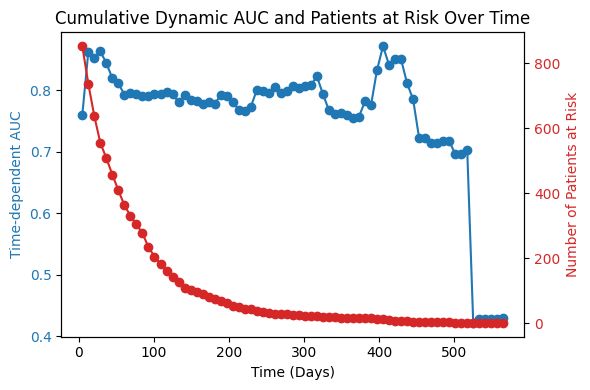

In [276]:
# Assuming 'time_steps' is already defined and corresponds to the times you've used in your AUC calculations

# Calculate the number of patients at risk at each time step
at_risk_counts = [y_test_surv[y_test_surv['time_to_final_weaning'] >= t].shape[0] for t in time_steps]

# Create the dual y-axis plot
fig, ax1 = plt.subplots(figsize=(6,4))

# Plot AUC on the left y-axis
color = 'tab:blue'
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Time-dependent AUC", color=color)
ax1.plot(time_steps, rsf_auc, "o-", label="RSF AUC", color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create another y-axis for the number of patients at risk
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel("Number of Patients at Risk", color=color)
ax2.plot(time_steps, at_risk_counts, "o-", label="Patients at Risk", color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and grid
plt.title("Cumulative Dynamic AUC and Patients at Risk Over Time")
fig.tight_layout()  # To fit the title and labels
plt.show()


In [22]:

def median_survival_time(surv_probs, time_points):
    """ Calculate the median survival time for given survival probabilities. """
    median_time = np.array([time_points[np.argmax(sp <= 0.5)] if np.any(sp <= 0.5) else time_points[-1] for sp in surv_probs])
    return median_time

# Calculating estimated weaning times
rsf_estimated_weaning = median_survival_time(rsf_surv_prob, time_steps)
cph_estimated_weaning = median_survival_time(cph_surv_prob, time_steps)
random_estimated_weaning = median_survival_time(random_surv_prob, time_steps)
km_estimated_weaning = median_survival_time(km_surv_prob, time_steps)

# Actual weaning times
actual_weaning_times = y_test_surv["time_to_final_weaning"]

# Computing errors
models = {
    "RSF": rsf_estimated_weaning,
    "CPH": cph_estimated_weaning,
    "Random": random_estimated_weaning,
    "Kaplan-Meier": km_estimated_weaning
}
errors = {model: predictions - actual_weaning_times for model, predictions in models.items()}

# Computing MAE, RMSE, MAPE
def compute_metrics(errors):
    mae = np.mean(np.abs(errors))
    rmse = np.sqrt(np.mean(errors**2))
    mape = np.mean(np.abs(errors / actual_weaning_times)) * 100  # in percentage
    return mae, rmse, mape

metrics = pd.DataFrame(
    {model: compute_metrics(err) for model, err in errors.items()},
    index=["MAE", "RMSE", "MAPE"]
).T

print(metrics.round(3))


                 MAE     RMSE     MAPE
RSF           67.423  113.812  160.798
CPH           63.453  104.206  207.815
Random        95.659  146.132   94.298
Kaplan-Meier  72.139  115.781  301.507


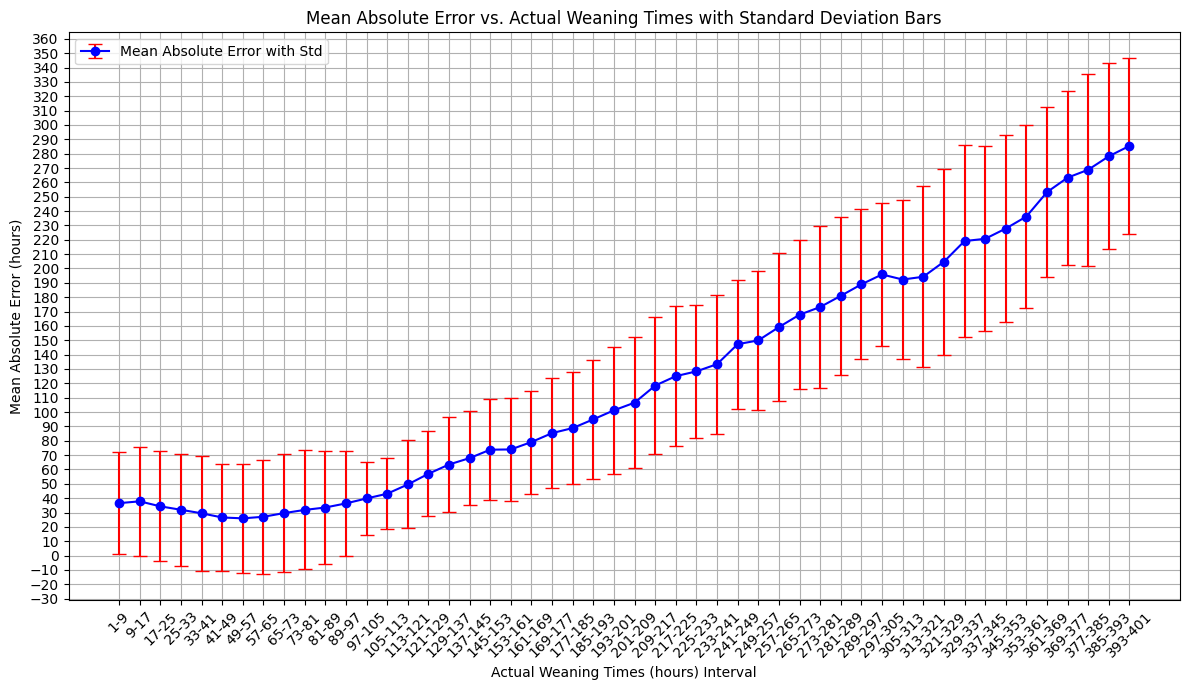

In [300]:

# Sample data setup (ensure actual_weaning_times and rsf_abs_error are already defined)
data = pd.DataFrame({
    'Actual Weaning Time': actual_weaning_times,
    'Absolute Error': np.abs(errors['RSF'])
})

data = data[data['Actual Weaning Time']<400]

# Bin the data into groups based on actual weaning times
bin_width = 8  # Adjust this based on the range and distribution of your data
bins = np.arange(start=data['Actual Weaning Time'].min(), stop=data['Actual Weaning Time'].max() + bin_width, step=bin_width)
data['Time Bin'] = pd.cut(data['Actual Weaning Time'], bins=bins, include_lowest=True, right=False)

# Calculate mean and variance of absolute errors for each bin
grouped_data = data.groupby('Time Bin')['Absolute Error'].agg(['mean', 'std'])

# Calculate mid points of the bins for plotting
mid_points = [interval.mid for interval in grouped_data.index.categories]

# Plotting
plt.figure(figsize=(12, 7))
plt.errorbar(x=mid_points, y=grouped_data['mean'], yerr=grouped_data['std'], fmt='o-', ecolor='red', capsize=5, color='blue', label='Mean Absolute Error with Std')
plt.xticks(ticks=mid_points, labels=[f"{int(interval.left)}-{int(interval.right)}" for interval in grouped_data.index.categories], rotation=45)


# Set the interval between ticks
interval = 10  # Adjust this value to set your desired gap between ticks on the y-axis

# Setup the y-axis to use the MultipleLocator for ticking
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(interval))


plt.title('Mean Absolute Error vs. Actual Weaning Times with Standard Deviation Bars')
plt.xlabel('Actual Weaning Times (hours) Interval')
plt.ylabel('Mean Absolute Error (hours)')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()


The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).


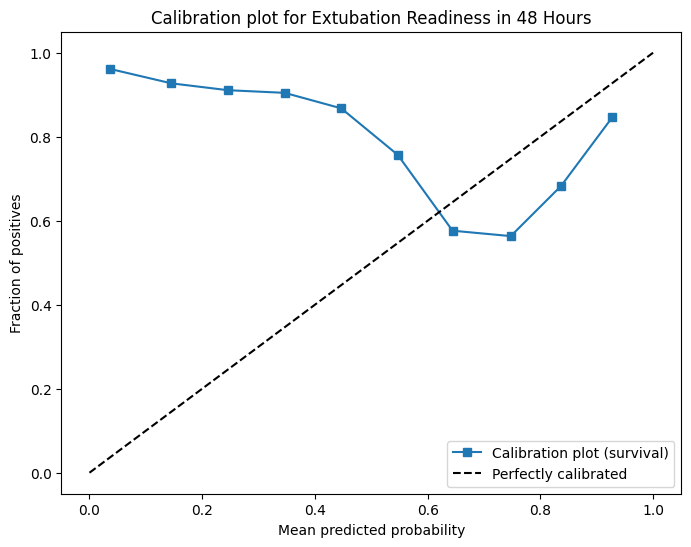

In [318]:
from sklearn.calibration import calibration_curve

time_point_index = np.where(time_steps == 48)[0][0]  # Check for 1-year survival, adjust as necessary
predicted_probabilities = cph_surv_prob[:, time_point_index]

# Prepare the actual event data
time_to_event = y_test_surv['time_to_final_weaning']
event_occurred = y_test_surv['event']

# Generate calibration data
fraction_of_positives, mean_predicted_value = calibration_curve(event_occurred, predicted_probabilities, n_bins=10, normalize=True)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration plot (survival)')
plt.plot([0, 1], [0, 1], "k--", label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot for Extubation Readiness in 48 Hours')
plt.legend()
plt.show()


### Refit with all data or improve the calibration through test dataset?

## Deeplearning based approaches

In [29]:
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv



np.random.seed(1234)
_ = torch.manual_seed(123)



## Evaluate on EF cases

In [292]:
df_ef_tmp = df_ef.groupby('encounterId').apply(
    lambda x: x.loc[x.timestamp == (x.first_extubation_time.iloc[-1] - 1)]).reset_index(drop=True)
df_ef_tmp['encounterId_ordered'] = pd.Categorical(df_ef_tmp['encounterId'], categories=EF_id_list, ordered=True)
df_ef_tmp = df_ef_tmp.sort_values('encounterId_ordered')
df_ef_tmp.drop('encounterId_ordered', axis=1, inplace=True)  # Optional: drop the helper column
X_test_reintub = df_ef_tmp[X_test.columns]
X_test_reintub[cols_to_transform] = scaler.transform(X_test_reintub[cols_to_transform])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [301]:
rsf_surv_prob = np.row_stack([fn(time_steps) for fn in rsf_model.predict_survival_function(X_test_reintub)])
rsf_estimated_weaning = median_survival_time(rsf_surv_prob, time_steps)
df_ef_tmp['estimated_TTE'] = rsf_estimated_weaning

In [302]:
# Group by 'event_description' and calculate the counts where 'estimated_TTE' > 40
counts_gt_40 = df_ef_tmp[df_ef_tmp['estimated_TTE'] > 40].groupby('event_description').size()

# Calculate the total counts for each group
total_counts = df_ef_tmp.groupby('event_description').size()

# Calculate proportions by dividing the counts of 'estimated_TTE' > 40 by the total group size
counts_gt_40 / total_counts


event_description
No 48h Observation - Alive       0.139831
No 48h Observation - Deceased    1.000000
Not Extubated - Alive            0.500000
Not Extubated - Deceased         1.000000
Successful Extubation            0.165375
dtype: float64

In [303]:
# Merge EF_data with df_ef_tmp on 'encounterId'
EF_encounterId_df = pd.DataFrame({
    'encounterId': EF_data['encounterId'],
    'y_test': EF_data['y_test']
})

merged_data = pd.merge(EF_encounterId_df, df_ef_tmp[['encounterId']], on='encounterId', how='inner')



In [304]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, make_scorer, precision_recall_curve, average_precision_score

threshold_time = 40
time_index = np.where(time_steps == threshold_time)[0][0] 
y_ef_proba = rsf_surv_prob[:, time_index]
y_ef_pred = (rsf_estimated_weaning>threshold_time).astype(int)
y_ef_test = merged_data['y_test']

accuracy = accuracy_score(y_ef_test, y_ef_pred)
precision_metric = precision_score(y_ef_test, y_ef_pred, zero_division=1)
recall_metric = recall_score(y_ef_test, y_ef_pred, zero_division=1)
f1 = f1_score(y_ef_test, y_ef_pred, zero_division=1)


roc_auc = roc_auc_score(y_ef_test, y_ef_proba)

precision, recall, _ = precision_recall_curve(y_ef_test, y_ef_proba)
auprc = auc(recall, precision)


print("Confusion Matrix:\n", confusion_matrix(y_ef_test, y_ef_pred))

print("Accuracy:", accuracy)
print("Precision:", precision_metric)
print("Recall:", recall_metric)
print("F1-score:", f1)
print("ROC-AUC:", roc_auc)
print("AUPRC:", auprc)
print("Classification Report:\n", classification_report(y_ef_test, y_ef_pred))
    


Confusion Matrix:
 [[698 114]
 [ 32  21]]
Accuracy: 0.8312138728323699
Precision: 0.15555555555555556
Recall: 0.39622641509433965
F1-score: 0.22340425531914895
ROC-AUC: 0.6928385537689375
AUPRC: 0.25488172726214237
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91       812
           1       0.16      0.40      0.22        53

    accuracy                           0.83       865
   macro avg       0.56      0.63      0.56       865
weighted avg       0.91      0.83      0.86       865




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


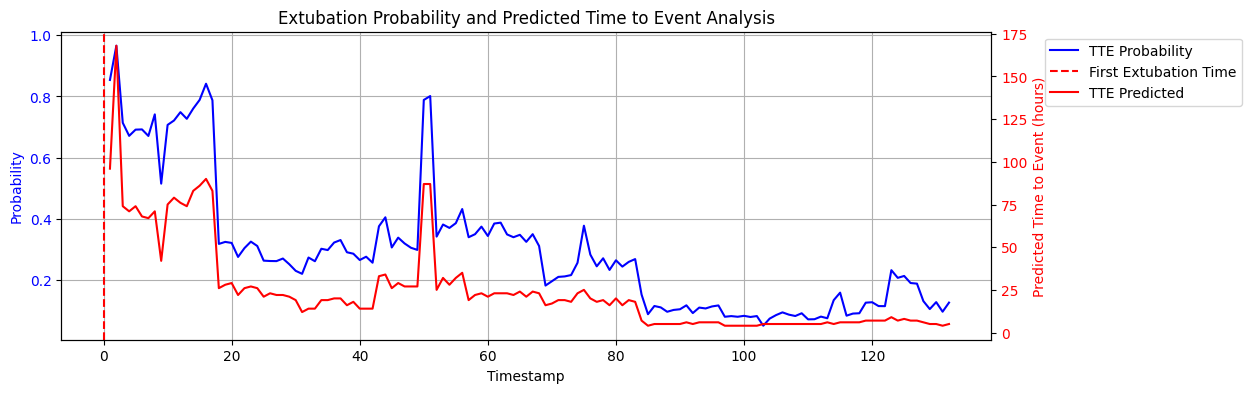

,encounterId,vent_start_time,vent_end_time,num_intub,event_description
619,16866,0,84,1,Successful Extubation


In [298]:
check_id = '16866'

tmp_df = df_ef.loc[df_ef.encounterId==check_id].copy()
tmp_df.sort_values(by='timestamp', inplace=True)
tmp_X = tmp_df[X_test.columns]
tmp_result = tmp_df[['timestamp']].copy()
tmp_X[cols_to_transform] = scaler.transform(tmp_X[cols_to_transform])

rsf_surv_prob_tmp = np.row_stack([fn(time_steps) for fn in rsf_model.predict_survival_function(tmp_X)])
rsf_estimated_weaning_tmp = median_survival_time(rsf_surv_prob_tmp, time_steps)
tmp_result[f"TTE_proba"] = rsf_surv_prob_tmp[:, time_index]
tmp_result[f"TTE_pred"] = rsf_estimated_weaning_tmp

reintubation_time = tmp_df.loc[(tmp_df['airwayStatus_Intubated'] == 1) & 
                                                  (tmp_df['timestamp'] > tmp_df.first_extubation_time), 'timestamp']
if not reintubation_time.empty:
    reintubation_time = reintubation_time.iloc[0]
    first_extubation_x = tmp_df.loc[tmp_df.timestamp==tmp_df['first_extubation_time'].iloc[0], 'timestamp'].iloc[0]
    reintubation_x = tmp_df.loc[tmp_df.timestamp==reintubation_time, 'timestamp'].iloc[0]
else:
    first_extubation_x = 0
    reintubation_x = 0
    
plt.figure(figsize=(12,4))

# Create the first subplot for the survival probability over time
ax1 = plt.gca()  # Get current axis
ax1.plot(tmp_result['timestamp'], tmp_result['TTE_proba'], 'b-', label='TTE Probability')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Probability', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Mark the first extubation and reintubation times
ax1.axvline(x=first_extubation_x, color='red', linestyle='--', label='First Extubation Time')
if reintubation_x != 0:
    ax1.axvline(x=reintubation_x, color='green', linestyle='--', label='Reintubation Time')

# Create a second y-axis for the predicted time to event
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(tmp_result['timestamp'], tmp_result['TTE_pred'], 'r-', label='TTE Predicted')
ax2.set_ylabel('Predicted Time to Event (hours)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding legend to the plot
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Extubation Probability and Predicted Time to Event Analysis')
plt.show()
vent_outcome[vent_outcome.encounterId==check_id]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


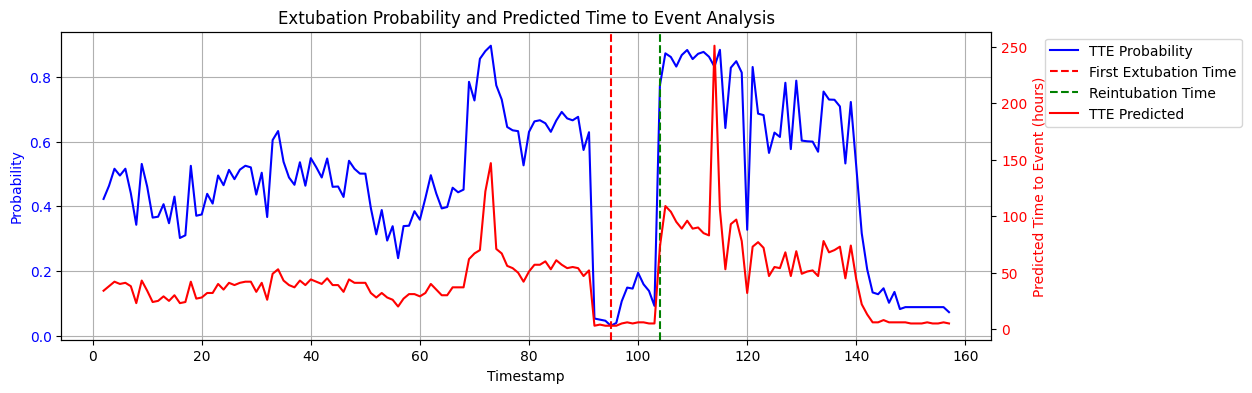

,encounterId,vent_start_time,vent_end_time,num_intub,event_description
2362,NIC:1042523:1767795000,1,143,2,No 48h Observation - Alive


In [299]:
check_id = 'NIC:1042523:1767795000'

tmp_df = df_ef.loc[df_ef.encounterId==check_id].copy()
tmp_df.sort_values(by='timestamp', inplace=True)
tmp_X = tmp_df[X_test.columns]
tmp_result = tmp_df[['timestamp']].copy()
tmp_X[cols_to_transform] = scaler.transform(tmp_X[cols_to_transform])

rsf_surv_prob_tmp = np.row_stack([fn(time_steps) for fn in rsf_model.predict_survival_function(tmp_X)])
rsf_estimated_weaning_tmp = median_survival_time(rsf_surv_prob_tmp, time_steps)
tmp_result[f"TTE_proba"] = rsf_surv_prob_tmp[:, time_index]
tmp_result[f"TTE_pred"] = rsf_estimated_weaning_tmp

reintubation_time = tmp_df.loc[(tmp_df['airwayStatus_Intubated'] == 1) & 
                                                  (tmp_df['timestamp'] > tmp_df.first_extubation_time), 'timestamp']
if not reintubation_time.empty:
    reintubation_time = reintubation_time.iloc[0]
    first_extubation_x = tmp_df.loc[tmp_df.timestamp==tmp_df['first_extubation_time'].iloc[0], 'timestamp'].iloc[0]
    reintubation_x = tmp_df.loc[tmp_df.timestamp==reintubation_time, 'timestamp'].iloc[0]
else:
    first_extubation_x = 0
    reintubation_x = 0
    
plt.figure(figsize=(12,4))

# Create the first subplot for the survival probability over time
ax1 = plt.gca()  # Get current axis
ax1.plot(tmp_result['timestamp'], tmp_result['TTE_proba'], 'b-', label='TTE Probability')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Probability', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Mark the first extubation and reintubation times
ax1.axvline(x=first_extubation_x, color='red', linestyle='--', label='First Extubation Time')
if reintubation_x != 0:
    ax1.axvline(x=reintubation_x, color='green', linestyle='--', label='Reintubation Time')

# Create a second y-axis for the predicted time to event
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(tmp_result['timestamp'], tmp_result['TTE_pred'], 'r-', label='TTE Predicted')
ax2.set_ylabel('Predicted Time to Event (hours)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding legend to the plot
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title('Extubation Probability and Predicted Time to Event Analysis')
plt.show()
vent_outcome[vent_outcome.encounterId==check_id]

In [306]:
y_test_surv

array([( True, 105.), ( True, 104.), ( True, 103.), ..., ( True,   3.),
       ( True,   2.), ( True,   1.)],
      dtype=[('event', '?'), ('time_to_final_weaning', '<f8')])

# Draft

In [13]:
# Standardization
df_train_val = df_baselines.loc[df_baselines.encounterId.isin(id_list_train_val)]
df_test = df_baselines.loc[df_baselines.encounterId.isin(id_list_test)]

# # Calculate mean and std for each age group in the training set
# age_group_stats = df_train_val.groupby('age_group')[age_dependent_cols].agg(['mean', 'std'])

# for col in age_dependent_cols:
#     for age_group in age_group_stats.index:
#         # Get mean and std for the age group
#         group_mean = age_group_stats.loc[age_group, (col, 'mean')]
#         group_std = age_group_stats.loc[age_group, (col, 'std')]

#         # Apply transformation for the training set
#         df_train_val.loc[df_train_val['age_group'] == age_group, col] = (df_train_val.loc[df_train_val['age_group'] == age_group, col] - group_mean) / group_std

#         # Apply the same transformation to the test set
#         df_test.loc[df_test['age_group'] == age_group, col] = (df_test.loc[df_test['age_group'] == age_group, col] - group_mean) / group_std

# Standardization for other numerical columns
scaler = MinMaxScaler()
cols_to_transform = ['age_group', 'weight', 'PIM'] + numerical_cols_for_pred
df_train_val[cols_to_transform] = scaler.fit_transform(df_train_val[cols_to_transform])
df_test[cols_to_transform] = scaler.transform(df_test[cols_to_transform])  # Apply same transformation to test data



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# Split the data, retaining 'encounterId' and 'timestamp'
X_train = df_train_val[prediction_features+demo_cols]
X_test = df_test[prediction_features+demo_cols]
y_train = df_train_val['extubation_ready']
y_test = df_test['extubation_ready']
y_test_tracker = df_test[['encounterId', 'timestamp']]

In [15]:
# For weaning readiness predcition

# Convert the pandas DataFrame to a numpy array first
X_train_numpy = X_train.to_numpy().astype(np.float32)
y_train_numpy = y_train.to_numpy().astype(np.float32).reshape(-1, 1)  # assuming y_train_log is a Series
X_test_numpy = X_test.to_numpy().astype(np.float32)
y_test_numpy = y_test.to_numpy().astype(np.float32).reshape(-1, 1)

# Now convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_numpy)
y_train_tensor = torch.from_numpy(y_train_numpy)
X_test_tensor = torch.from_numpy(X_test_numpy)
y_test_tensor = torch.from_numpy(y_test_numpy)    

In [16]:

# Assuming df is your DataFrame and it's already sorted by encounterId and timestamp

def create_sequences(df, selected_features, label_col, time_col='timestamp_original', context_len=1000, largest_lov=24*28, \
                         window_size=1, noise_level=0.):
    sequences = []
    labels = []
    id_tracker = []
    timestamp_tracker = []
    for encounter_id, group in df.groupby('encounterId'):
        encounter_data = group.reset_index(drop=True)  # Reset index if not already sequential
        for i in range(1, len(encounter_data)+1, window_size):
            start_idx = max(0, i - context_len)
            seq = encounter_data.iloc[start_idx:i]
            label = int(seq[label_col].iloc[-1])
            timestamp = int(seq[time_col].iloc[-1])
            
            seq = seq[selected_features]
            noise = np.random.normal(0, noise_level, seq.shape)
            noisy_seq = seq.values + noise
            sequences.append(noisy_seq)
            labels.append(label)
            id_tracker.append(encounter_id)
            timestamp_tracker.append(timestamp)

    return sequences, labels, id_tracker, timestamp_tracker

sequence_length = 48

df_train = df_train_val.loc[df_train_val.encounterId.isin(id_list_train)]
df_val = df_train_val.loc[df_train_val.encounterId.isin(id_list_val)]

sequences_train, labels_train, id_tracker_train, timestamp_tracker_train = create_sequences(df_train, prediction_features, 'extubation_ready', \
                                                     context_len=sequence_length)
sequences_val, labels_val, id_tracker_val, timestamp_tracker_val = create_sequences(df_val, prediction_features, 'extubation_ready', \
                                                     context_len=sequence_length)
sequences_test, labels_test, id_tracker_test, timestamp_tracker_test = create_sequences(df_test, prediction_features, 'extubation_ready', \
                                                   context_len=sequence_length)


In [17]:
# convert into Tensors
def sequences_to_tensor(sequences):
    tensor_seqs = [torch.tensor(s, dtype=torch.float32) for s in sequences]
    return pad_sequence(tensor_seqs, batch_first=True, padding_value=-1)

X_seq_train_tensor = sequences_to_tensor(sequences_train)
X_seq_val_tensor = sequences_to_tensor(sequences_val)
X_seq_test_tensor = sequences_to_tensor(sequences_test)

y_seq_train_tensor = torch.tensor(labels_train, dtype=torch.float32).unsqueeze(-1)
y_seq_val_tensor = torch.tensor(labels_val, dtype=torch.float32).unsqueeze(-1)
y_seq_test_tensor = torch.tensor(labels_test, dtype=torch.float32).unsqueeze(-1)



In [18]:
train_raw = {'data': [X_seq_train_tensor.numpy(), labels_train], 
             'names': id_tracker_train, 
             'timestamp_tracker': timestamp_tracker_train}
val_raw = {'data': [X_seq_val_tensor.numpy(), labels_val], 
             'names': id_tracker_val, 
             'timestamp_tracker': timestamp_tracker_val}
test_raw = {'data': [X_seq_test_tensor.numpy(), labels_test], 
             'names': id_tracker_test, 
             'timestamp_tracker': timestamp_tracker_test}

In [19]:
demo_tmp = pd.concat([df_train, df_val, df_test], axis=0)[['encounterId']+demo_cols].drop_duplicates()
demo_info = {'idx_list': demo_tmp.encounterId.tolist(), 
             'demographic_data': [row.to_numpy() for index, row in 
                        demo_tmp.loc[:, demo_tmp.columns != 'encounterId'].iterrows()]}

In [20]:
pd.to_pickle([train_raw, val_raw, test_raw, demo_info], './prep_datasets_for_seq_modelling.pkl')

In [25]:
X_seq_train_val_tensor = torch.concat([X_seq_train_tensor, X_seq_val_tensor])
y_seq_train_val_tensor = torch.concat([y_seq_train_tensor, y_seq_val_tensor])



### Niaive ML

In [37]:
# AUC plot
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))
    
    for name, model in models.items():
        # Compute ROC curve and ROC area for each model
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    

def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(8,6))

    for name, model in models.items():
        # Compute Precision-Recall curve and AUPRC for each model
        precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
        pr_auc = auc(recall, precision)
        
        plt.plot(recall, precision, lw=2, label=f'{name} (AUPRC = {pr_auc:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

def train_and_evaluate_models(X_train, y_train, X_test, y_test, scorer, reweight_class=False, tuning=False,
                              print_detail_results=False, visual=True, silent_mode=False):

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), \
                                 y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    if not reweight_class:
        class_weight_dict = {key: class_weight_dict[key]*0.5 for key, value in enumerate(class_weight_dict)}

    # Hyperparameter grids
    log_reg_params = {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    }

    random_forest_params = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30]
    }

    knn_params = {"n_neighbors": [3, 5, 7, 10], 
                  "weights": ["uniform", "distance"], 
                  "metric": ["euclidean", "manhattan"]}

    naive_bayes_params = {"var_smoothing": [1e-9, 1e-8, 1e-7]}

    # For AdaBoost, consider the number of estimators and learning rate
    ada_boost_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1]
    }

    # For MLP, consider the number of layers and neurons, and the learning rate
    mlp_params = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
        'alpha': [0.0001, 0.01]
    }

    # For SVM, consider the C parameter and the kernel type
    svm_params = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }


    # For Gradient Boosting, consider the number of estimators, learning rate, and max depth
    gbdt_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [1, 3, 5]
    }

    # For XGBoost, consider the number of estimators, learning rate, and max depth
    xgboost_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }


    # For LightGBM, consider the number of estimators, learning rate, and max depth
    lightgbm_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50],
        'force_col_wise': [True],
        'verbose': [-1]
    }
    if tuning:
        # Define your models with hyperparameter grids...
        models = {
            "Logistic Regression": (LogisticRegression(max_iter=1000, class_weight=class_weight_dict), log_reg_params),
            "Random Forest": (RandomForestClassifier(class_weight=class_weight_dict), random_forest_params),
            "AdaBoost": (AdaBoostClassifier(), ada_boost_params),
        #     "KNN": (KNeighborsClassifier(), knn_params),
            "NaiveBayes": (GaussianNB(), naive_bayes_params),
#             "MLP": (MLPClassifier(max_iter=5000), mlp_params),
            "SVM": (SVC(probability=True, class_weight=class_weight_dict), svm_params),
            "GBDT": (GradientBoostingClassifier(), gbdt_params),
            "XGBoost": (XGBClassifier(scale_pos_weight=class_weights[1] / class_weights[0]), xgboost_params),
            "LightGBM": (LGBMClassifier(scale_pos_weight=class_weights[1] / class_weights[0]), lightgbm_params)
        }

        trained_baselines = {}
        if not silent_mode:
            print('=' * 100)
        for name, (model, params) in models.items():
            if not silent_mode:
                print(f"Training {name} with hyperparameter tuning...")
            grid_search = GridSearchCV(model, params, cv=5, scoring=scorer, refit=True)
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            trained_baselines[name] = best_model
            if not silent_mode:
                print(f"Best params for {name}: ", grid_search.best_params_)
                print(f"Best score for {name}: ", grid_search.best_score_)
    else:
        # Without hyperparameter tuning...
        models = {
            "Logistic Regression": LogisticRegression(max_iter=5000, class_weight=class_weight_dict),
            "Random Forest": RandomForestClassifier(class_weight=class_weight_dict),
#             "KNN": KNeighborsClassifier(),
            "AdaBoost": AdaBoostClassifier(),
#             "MLP": MLPClassifier(max_iter=5000),  # Increased max_iter for convergence
#             "SVM": SVC(probability=True, class_weight=class_weight_dict),  # Ensure we can get probability estimates
            "NaiveBayes": GaussianNB(),
            "GBDT": GradientBoostingClassifier(),
            "XGBoost": XGBClassifier(scale_pos_weight = class_weights[1] / class_weights[0]),
            "LightGBM": LGBMClassifier(scale_pos_weight = class_weights[1] / class_weights[0], verbose=-1)
        }
        
        trained_baselines = {}
        if not silent_mode:
            print('='*100)
        for name, model in models.items():
            if not silent_mode:
                print(f"Training {name}...")
            model.fit(X_train, y_train)
            trained_baselines[name] = model

    # 3. Model Evaluation:
    if not silent_mode:
        print('='*100)
    evaluation_results = {}
    for name, model in trained_baselines.items():
        # Model evaluation code...

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

        # Computing various metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision_metric = precision_score(y_test, y_pred)
        recall_metric = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)
        
        # Computing Precision-Recall curve and AUPRC
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        auprc = auc(recall, precision)

        if not silent_mode:
            print(f"Evaluation for {name}:")
            print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
            if print_detail_results:
                print("Accuracy:", accuracy)
                print("Precision:", precision_metric)
                print("Recall:", recall_metric)
                print("F1-score:", f1)
                print("ROC-AUC:", roc_auc)
                print("AUPRC:", auprc)
                print("Classification Report:\n", classification_report(y_test, y_pred))
            print("-" * 50)

        # Store evaluation results...
        evaluation_results[name] = {
            "Accuracy": accuracy,
            "Precision": precision_metric,
            "Recall": recall_metric,
            "F1-score": f1,
            "ROC-AUC": roc_auc,
            "AUPRC": auprc,
            "Confusion Matrix": confusion_matrix(y_test, y_pred).tolist(),  # Convert to list for JSON serializability if needed
            "Classification Report": classification_report(y_test, y_pred)
        }

    if visual and not silent_mode:
        # Plotting functions...
        plot_roc_curve(trained_baselines, X_test, y_test)
        plot_precision_recall_curve(trained_baselines, X_test, y_test)
    # Return both the trained models and their evaluation results
    return trained_baselines, evaluation_results


In [38]:
from collections import Counter
import numpy as np

class MajorityVotingClassifier:
    def __init__(self, y_train):
        self.majority_class = Counter(y_train).most_common(1)[0][0]
        self.classes_ = np.unique(y_train)

    def fit(self, X, y):
        # Fit method is not needed for this model but included for compatibility
        pass

    def predict(self, X):
        return np.array([self.majority_class] * len(X))

    def predict_proba(self, X):
        # Assuming binary classification for simplicity
        proba = np.zeros((len(X), len(self.classes_)))
        class_index = list(self.classes_).index(self.majority_class)
        proba[:, class_index] = 1
        return proba


class RandomSelectorBasedOnClassWeights:
    def __init__(self, y_train):
        self.class_counts = Counter(y_train)
        self.total_count = sum(self.class_counts.values())
        self.class_weights = {cls: count / self.total_count for cls, count in self.class_counts.items()}
        self.classes_ = np.array(list(self.class_weights.keys()))

    def fit(self, X, y):
        # Fit method is not needed for this model but included for compatibility
        pass

    def predict(self, X):
        probabilities = list(self.class_weights.values())
        return np.random.choice(self.classes_, size=len(X), p=probabilities)

    def predict_proba(self, X):
        # This returns the same class distribution probabilities for each instance
        probabilities = np.array(list(self.class_weights.values()))
        random_probs = np.tile(probabilities, (len(X), 1))
        return random_probs

    

In [58]:

# # Sample the indices
# sample_indices = np.random.choice(len(X_train), size=int(len(X_train)*.1), replace=False)

# # Create the sampled datasets
# X_train_resampled = X_train.iloc[sample_indices]
# y_train_resampled = y_train.iloc[sample_indices]

# # Feature Selection using RFE with cross-validation:
# print('='*100)
# selector = RFECV(estimator=LogisticRegression(max_iter=10000), step=1, cv=5)
# selector = selector.fit(X_train_resampled, y_train_resampled)
# selected_features = X_train_resampled.columns[selector.support_]
# print(f'Total of {len(selected_features)} features has been selected:\n', selected_features)

# # Use only selected features for training and testing
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# using full list of variables
X_train_selected = X_train
X_test_selected = X_test

# # Handling Imbalanced Data using Random Oversampling
# rus = RandomUnderSampler(sampling_strategy=1., random_state=66)
# X_train_selected, y_train_selected = rus.fit_resample(X_train_selected, y_train.values.ravel())


In [ ]:
scorer = make_scorer(average_precision_score, needs_proba=True) 

naive_baselines, _ = train_and_evaluate_models(X_train_selected, y_train, X_test_selected, y_test, scorer,
                         reweight_class=True, tuning=False, print_detail_results=False, visual=False)


Training Logistic Regression with hyperparameter tuning...
Best params for Logistic Regression:  {'C': 0.1, 'solver': 'lbfgs'}
Best score for Logistic Regression:  0.625136107153814
Training Random Forest with hyperparameter tuning...
Best params for Random Forest:  {'max_depth': 10, 'n_estimators': 100}
Best score for Random Forest:  0.6225734522986686
Training AdaBoost with hyperparameter tuning...
Best params for AdaBoost:  {'learning_rate': 0.1, 'n_estimators': 150}
Best score for AdaBoost:  0.6197958875093376
Training NaiveBayes with hyperparameter tuning...
Best params for NaiveBayes:  {'var_smoothing': 1e-07}
Best score for NaiveBayes:  0.5558441850225397
Training MLP with hyperparameter tuning...


In [ ]:
# risk_baselines['Majority Voter'] = MajorityVotingClassifier(y_train_resampled)
naive_baselines['Random Selector'] = RandomSelectorBasedOnClassWeights(y_train_resampled)
plot_roc_curve(naive_baselines, X_test_selected, y_test)
plot_precision_recall_curve(naive_baselines, X_test_selected, y_test)

### MLP

In [26]:


def train_model(model_train, train_loader, num_epochs, optimizer, criterion, scheduler=None, \
                device='cpu', silent_mode=True, early_stopping_patience=3):
    model_train.to(device)
    model_train.train()
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):

        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model_train(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            
        avg_loss = total_loss / len(train_loader)
        
        if scheduler: scheduler.step(avg_loss)
            
        if not silent_mode: print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss:.4f}')

        if early_stopping_patience:
            if avg_loss < best_val_loss:
                best_val_loss = avg_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= early_stopping_patience:
                    if not silent_mode: print("Early stopping triggered.")
                    break

    return model_train

def evaluate_model(model_eval, data_loader, eval_fn, device='cpu'):
    if next(model_eval.parameters()).device != device: model_eval.to(device)
    model_eval.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model_eval(X_batch)
                    
            predictions.extend(outputs.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
            
    return eval_fn(targets, predictions)

def hyperparameter_search(model_class, X, y, params_grid, criterion_fn, eval_fn, num_epochs, n_fold=5, \
                          device='cpu', silent_mode=True):
    kf = KFold(n_splits=n_fold)
    input_dim = X.shape[-1]
    scores = []
 
    for params in params_grid:
        print("Testing parameters:", params)
        fold_scores = []
            
        for train_index, val_index in kf.split(X.numpy()):  # Assuming X is a tensor
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]

            # DataLoader for training and validation set
            train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=params['batch_size'], shuffle=True)
            val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=params['batch_size'])

            # Initialize model, loss, and optimizer
            model = model_class(**{k: v for k, v in params.items() if k != 'batch_size' \
                                   and k != 'lr' and k != 'weight_decay'})
            optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
            criterion = criterion_fn()
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

            model = train_model(model, train_loader, num_epochs, optimizer, criterion, scheduler, \
                            device=device, silent_mode=silent_mode)
            val_result = evaluate_model(model, val_loader, eval_fn, device)
            fold_scores.append(val_result)
                    
        average_eval = np.mean(fold_scores, axis=0)
        params['score'] = average_eval
        scores.append(params)
        print(20*'*', params['score'], 20*'*')
        
    return scores


In [27]:

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),  # Dropout layer for regularization
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1)
#         )
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
#             nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def predict_proba(self, x):
        '''can take in numpy'''
        self.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(np.array(X_test_selected), dtype=torch.float32).to(next(self.parameters()).device)
            logits = self.forward(x_tensor).cpu()  # These are raw scores (logits)
            predicted_probas = torch.sigmoid(logits).numpy()  # Apply sigmoid to convert logits to probabilities
        return predicted_probas
    
    def predict(self, x):
        predicted_probas = self.predict_proba(x)
        predicted_classes = (predicted_probas >= 0.5).astype(int)
        return predicted_classes.squeeze()


In [32]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.view(-1).numpy()), \
                                 y=y_train_tensor.view(-1).numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
class_weights_tensor[1]

tensor(1.8816)

In [38]:
y_train_tensor.sum()

tensor(53332.)

In [34]:
y_train_tensor.shape

torch.Size([200698, 1])

In [28]:
def criterion_fn():
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.view(-1).numpy()), \
                                     y=y_train_tensor.view(-1).numpy())
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    return nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor[1])

def eval_fn(true, preds):
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # Convert raw predictions to probabilities
    preds = np.array(preds)
    predicted_probs = sigmoid(preds)
    # Calculate AUPRC
    auroc = roc_auc_score(true, predicted_probs)
    auprc = average_precision_score(true, predicted_probs)
    return [auroc, auprc]

In [ ]:
# indices = [X_train.columns.get_loc(feature) for feature in selected_features]

# indices_tensor = torch.tensor(indices, dtype=torch.long)

# X_train_tensor_selected = X_train_tensor[:, indices_tensor]
# X_test_tensor_selected = X_test_tensor[:, indices_tensor]

X_train_tensor_selected = X_train_tensor
X_test_tensor_selected = X_test_tensor


In [ ]:
num_epochs = 30

hyperparameters = {
    'lr': [1e-3, 1e-4],
    'weight_decay': [1e-4, 1e-5],
    'batch_size': [256, 128],
    # Add any model-specific parameters here
    'input_dim': [X_train_numpy.shape[1]]
#     'hidden_dim': [64, 128, 256],
#     'num_layers': [1, 2, 3],
#     'dropout': [0.1, 0.2, 0.3],
}

def generate_param_grid(hyperparameters):
    keys, values = zip(*hyperparameters.items())
    param_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return param_grid

params_grid = generate_param_grid(hyperparameters)

# all_params = list(product(hidden_dims, num_layers_options, dropout_rates, learning_rates, batch_sizes, weight_decays))
# num_samples = 10 
# params_grid = random.sample(all_params, num_samples)

# Run cross-validation
def random_sample_tensors(X, y, sample_size):
    indices = np.random.choice(np.arange(len(X)), size=sample_size, replace=False)
    X_sampled = X[indices]
    y_sampled = y[indices]
    return X_sampled, y_sampled    

sample_size = int(len(X_train_tensor)*.1)
X_train_tensor_resampled, y_train_tensor_resampled = random_sample_tensors(X_train_tensor_selected, y_train_tensor, sample_size)

cv_results = hyperparameter_search(MLP, X_train_tensor_resampled, y_train_tensor_resampled, params_grid, \
                                   criterion_fn, eval_fn, num_epochs, n_fold=3, device='cuda', silent_mode=True)

# Find the best parameters
best_params = max(cv_results, key=lambda x: x['score'][0])
print("Best parameters:", best_params)

In [55]:


# Parameters for regularization and optimization
weight_decay = 1e-4
initial_lr = 0.001   # Initial learning rate
batch_size = 256
num_epochs = 50

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor_selected, y_train_tensor.view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_mlp = MLP(input_dim=X_train_tensor_selected.shape[1])
criterion = criterion_fn()
optimizer = torch.optim.Adam(best_mlp.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.9, verbose=False)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_mlp = train_model(best_mlp, train_loader, num_epochs, optimizer, criterion, scheduler, \
                device=device, silent_mode=False, early_stopping_patience=5)

# Evaluate the model
best_mlp.eval()
with torch.no_grad():
    logits = best_mlp(X_test_tensor_selected.to(device)).cpu()  # These are raw scores (logits)
    predicted_probs = torch.sigmoid(logits).numpy()  # Apply sigmoid to convert logits to probabilities
    auprc = average_precision_score(y_test_tensor, predicted_probs)
    auroc = roc_auc_score(y_test_tensor, predicted_probs)
    predicted_classes = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions

print(f'RUPRC: {auprc}')
print(f'AUROC: {auroc}')
print(confusion_matrix(y_test, predicted_classes))


Epoch 1/50, Training Loss: 0.6148
Epoch 2/50, Training Loss: 0.5901
Epoch 3/50, Training Loss: 0.5815
Epoch 4/50, Training Loss: 0.5771
Epoch 5/50, Training Loss: 0.5730
Epoch 6/50, Training Loss: 0.5716
Epoch 7/50, Training Loss: 0.5692
Epoch 8/50, Training Loss: 0.5671
Epoch 9/50, Training Loss: 0.5659
Epoch 10/50, Training Loss: 0.5641
Epoch 11/50, Training Loss: 0.5635
Epoch 12/50, Training Loss: 0.5618
Epoch 13/50, Training Loss: 0.5604
Epoch 14/50, Training Loss: 0.5613
Epoch 15/50, Training Loss: 0.5590
Epoch 16/50, Training Loss: 0.5580
Epoch 17/50, Training Loss: 0.5579
Epoch 18/50, Training Loss: 0.5565
Epoch 19/50, Training Loss: 0.5565
Epoch 20/50, Training Loss: 0.5570
Epoch 21/50, Training Loss: 0.5572
Epoch 22/50, Training Loss: 0.5542
Epoch 23/50, Training Loss: 0.5546
Epoch 24/50, Training Loss: 0.5530
Epoch 25/50, Training Loss: 0.5523
Epoch 26/50, Training Loss: 0.5489
Epoch 27/50, Training Loss: 0.5509
Epoch 28/50, Training Loss: 0.5493
Epoch 29/50, Training Loss: 0

### Time-dependent model

In [29]:


# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss

In [37]:
num_epochs = 10

hyperparameters = {
    'lr': [1e-3, 1e-4, 1e-5],
    'weight_decay': [1e-4, 1e-5],
    'batch_size': [64, 128, 256],
    # Add any model-specific parameters here
    'input_dim': [X_train_numpy.shape[1]],
    'hidden_dim': [64, 128, 256, 512],
    'num_layers': [2, 3],
    'dropout': [0.1, 0.25, 0.5]
}

def generate_param_grid(hyperparameters, num_samples=None):
    keys, values = zip(*hyperparameters.items())
    all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    # If num_samples is provided and less than the total number of combinations,
    # randomly sample 'num_samples' parameter sets.
    if num_samples is not None and num_samples < len(all_combinations):
        return random.sample(all_combinations, num_samples)
    else:
        return all_combinations

params_grid = generate_param_grid(hyperparameters, num_samples=None)

# Run cross-validation
def random_sample_tensors(X, y, sample_size):
    indices = np.random.choice(np.arange(len(X)), size=sample_size, replace=False)
    X_sampled = X[indices]
    y_sampled = y[indices]
    return X_sampled, y_sampled    

sample_size = int(len(X_train_tensor)*.2)
X_train_tensor_resampled, y_train_tensor_resampled = random_sample_tensors(X_train_tensor, y_train_tensor, sample_size)

cv_results = hyperparameter_search(LSTMModel, X_train_tensor_resampled, y_train_tensor_resampled, params_grid, \
                                   criterion_fn, eval_fn, num_epochs, n_fold=3, device='cuda', silent_mode=True)

# Find the best parameters
best_params = max(cv_results, key=lambda x: x['score'][0])
print("Best parameters:", best_params)


Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.1}
******************** [0.8333196  0.62663308] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.25}
******************** [0.83262306 0.62521317] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.5}
******************** [0.83203705 0.62092174] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.1}
******************** [0.83453033 0.62802054] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.25}
**************

******************** [0.83055139 0.61988503] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.25}
******************** [0.830766   0.62267027] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5}
******************** [0.82830791 0.61644391] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.1}
******************** [0.83150876 0.62518513] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.25}
******************** [0.82917869 0.62059131] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 0.0001, 'batch_size': 128, 'input_

******************** [0.83421664 0.62767316] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.25}
******************** [0.83386484 0.63120682] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5}
******************** [0.83352523 0.62875219] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.1}
******************** [0.83432754 0.6261111 ] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.25}
******************** [0.83409669 0.62801928] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 

******************** [0.83091365 0.62301283] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.25}
******************** [0.83124311 0.62365878] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.5}
******************** [0.83055435 0.6180265 ] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.1}
******************** [0.83218755 0.62178411] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.25}
******************** [0.8293732 0.6137145] ********************
Testing parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37,

******************** [0.81959674 0.59099   ] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.25}
******************** [0.81790694 0.58844105] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.5}
******************** [0.81917569 0.58947918] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.1}
******************** [0.81974799 0.59089185] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.25}
******************** [0.81828929 0.58737045] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 64, 'input_

******************** [0.79324007 0.53140501] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.25}
******************** [0.79378544 0.53685771] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.5}
******************** [0.79365249 0.53578362] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1}
******************** [0.80302369 0.556081  ] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.25}
******************** [0.80257588 0.55374688] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 0.0001, 'batch_size': 256, 'inp

******************** [0.82554    0.60267602] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.25}
******************** [0.82306121 0.59654616] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.5}
******************** [0.82319147 0.5965467 ] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.1}
******************** [0.82540243 0.60417727] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.25}
******************** [0.82090752 0.59173568] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim':

******************** [0.80284745 0.55433023] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.25}
******************** [0.80266104 0.55469832] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.5}
******************** [0.80103979 0.55227101] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.1}
******************** [0.81034407 0.56998966] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.25}
******************** [0.80784236 0.56785488] ********************
Testing parameters: {'lr': 0.0001, 'weight_decay': 1e-05, 'batch_size': 256, 'input_

******************** [0.73823133 0.4310578 ] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.25}
******************** [0.73735782 0.43165793] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.5}
******************** [0.73800104 0.42851497] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.1}
******************** [0.73321092 0.4259056 ] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.25}
******************** [0.73075042 0.42365209] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 128, 'input_dim'

******************** [0.74919922 0.43935714] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.25}
******************** [0.74621034 0.43580826] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5}
******************** [0.7461173  0.43526278] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.1}
******************** [0.76921456 0.49058111] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 2, 'dropout': 0.25}
******************** [0.77194553 0.49287877] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 0.0001, 'batch_size': 256, 'input_

******************** [0.74814868 0.45096938] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.25}
******************** [0.7462389  0.44185759] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.5}
******************** [0.74652303 0.44289752] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.1}
******************** [0.74564134 0.43861886] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim': 37, 'hidden_dim': 128, 'num_layers': 3, 'dropout': 0.25}
******************** [0.7454628  0.43707824] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 128, 'input_dim':

******************** [0.76933685 0.4899801 ] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.25}
******************** [0.77029404 0.48804693] ********************
Testing parameters: {'lr': 1e-05, 'weight_decay': 1e-05, 'batch_size': 256, 'input_dim': 37, 'hidden_dim': 512, 'num_layers': 3, 'dropout': 0.5}
******************** [0.77041584 0.48598319] ********************
Best parameters: {'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 64, 'input_dim': 37, 'hidden_dim': 64, 'num_layers': 3, 'dropout': 0.1, 'score': array([0.83760578, 0.6327344 ])}


In [30]:
num_epochs = 5

# final_params = best_params
final_params = {
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'batch_size': 128,
    # Add any model-specific parameters here
    'input_dim': X_seq_train_val_tensor.shape[1],
    'hidden_dim': 256,
    'num_layers': 2,
    'dropout': 0.25
}
# Initialize the best model
best_lstm = LSTMModel(X_seq_train_val_tensor.shape[-1], final_params['hidden_dim'], final_params['num_layers'], \
                      final_params['dropout'])

# Compute class weights for the entire dataset
# criterion = FocalLoss(alpha=0.8, gamma=3.0)
criterion = criterion_fn()
optimizer = optim.Adam(best_lstm.parameters(), lr=final_params['lr'], weight_decay=final_params['weight_decay'])
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  

# DataLoader for the entire training set
train_loader = DataLoader(TensorDataset(X_seq_train_val_tensor, y_seq_train_val_tensor), batch_size=final_params['batch_size'], shuffle=True)

# Training loop for the best model
for epoch in range(num_epochs):
    best_lstm.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = best_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    scheduler.step()
    if (epoch+1)%1==0:    
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
        # Evaluate the model
        best_lstm.eval()
        with torch.no_grad():
            predicted_probs = torch.sigmoid(best_lstm(X_seq_test_tensor)).squeeze().numpy()  # Apply sigmoid to get probabilities
            predicted_classes = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
            y_test_np = y_seq_test_tensor.numpy()  # Convert to numpy array for compatibility with sklearn metrics

            accuracy = accuracy_score(y_test_np, predicted_classes)
            precision = precision_score(y_test_np, predicted_classes)
            recall = recall_score(y_test_np, predicted_classes)
            f1 = f1_score(y_test_np, predicted_classes)
            roc_auc = roc_auc_score(y_test_np, predicted_probs)
            auprc = average_precision_score(y_test_np, predicted_probs)  # Calculate AUPRC
            report = classification_report(y_test_np, predicted_classes)
            confusion = confusion_matrix(y_test_np, predicted_classes)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-score: {f1:.4f}")
            print(f"ROC-AUC: {roc_auc:.4f}")
            print(f"AUPRC: {auprc:.4f}")  # Print AUPRC
            print("Classification Report:\n", report)
            print("Confusion Matrix:\n", confusion)

# Evaluate the model
best_lstm.eval()
with torch.no_grad():
    predicted_probs = torch.sigmoid(best_lstm(X_seq_test_tensor)).squeeze().numpy()  # Apply sigmoid to get probabilities
    predicted_classes = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    y_test_np = y_seq_test_tensor.numpy()  # Convert to numpy array for compatibility with sklearn metrics

    accuracy = accuracy_score(y_test_np, predicted_classes)
    precision = precision_score(y_test_np, predicted_classes)
    recall = recall_score(y_test_np, predicted_classes)
    f1 = f1_score(y_test_np, predicted_classes)
    roc_auc = roc_auc_score(y_test_np, predicted_probs)
    auprc = average_precision_score(y_test_np, predicted_probs)  # Calculate AUPRC
    report = classification_report(y_test_np, predicted_classes)
    confusion = confusion_matrix(y_test_np, predicted_classes)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"AUPRC: {auprc:.4f}")  # Print AUPRC
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", confusion)


Epoch 1/5, Loss: 0.5052
Accuracy: 0.7607
Precision: 0.5062
Recall: 0.6210
F1-score: 0.5577
ROC-AUC: 0.8005
AUPRC: 0.5575
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.81      0.84     42075
         1.0       0.51      0.62      0.56     13505

    accuracy                           0.76     55580
   macro avg       0.69      0.71      0.70     55580
weighted avg       0.78      0.76      0.77     55580

Confusion Matrix:
 [[33894  8181]
 [ 5119  8386]]
Epoch 2/5, Loss: 0.5213
Accuracy: 0.7375
Precision: 0.4736
Recall: 0.7199
F1-score: 0.5713
ROC-AUC: 0.8119
AUPRC: 0.5764
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.74      0.81     42075
         1.0       0.47      0.72      0.57     13505

    accuracy                           0.74     55580
   macro avg       0.68      0.73      0.69     55580
weighted avg       0.79      0.74      0.75     55580

Confus

## Bad Case Study

In [147]:
naive_baselines['MLP'] = best_mlp

models_to_investigate = ['Random Selector', \
                         'Logistic Regression', 'Random Forest', 'LightGBM']

# Initialize the outcome_df with the actual outcomes
outcome_df = y_test_tracker.copy()
outcome_df['actual'] = y_test
outcome_df = outcome_df.merge(df_baselines, on=['encounterId', 'timestamp'], how='left')

# Loop through each model to get predictions
for model_name in models_to_investigate:
    model = naive_baselines[model_name]
    y_pred = model.predict(X_test_selected)
    y_proba = model.predict_proba(X_test_selected)[:, -1]  # Probabilities for the positive class

    outcome_df[f'{model_name}_predicted'] = y_pred
    outcome_df[f'{model_name}_proba'] = y_proba
    outcome_df[f'{model_name}_correct'] = (outcome_df['actual'] == y_pred)
    # Optionally calculate and print accuracy for each model
    accuracy = roc_auc_score(outcome_df['actual'], y_proba)
    print(f"AUROC for {model_name}: {accuracy}")



You are merging on int and float columns where the float values are not equal to their int representation.


AUROC for Random Selector: 0.5
AUROC for Logistic Regression: 0.8371412215953632
AUROC for Random Forest: 0.8327583927289577
AUROC for LightGBM: 0.8434555982964992


In [278]:
best_lstm.eval()
with torch.no_grad():
    predicted_probs = torch.sigmoid(best_lstm(X_test_tensor)).squeeze().numpy()  # Apply sigmoid to get probabilities
    predicted_classes = (predicted_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
    
lstm_outcome_df = pd.DataFrame(tracker_test)
lstm_outcome_df['LSTM_predicted'] = predicted_classes
lstm_outcome_df['LSTM_proba'] = predicted_probs

outcome_df = outcome_df.merge(lstm_outcome_df, on=['encounterId', 'timestamp'])
outcome_df['LSTM_correct'] = (outcome_df['actual'] == outcome_df['LSTM_predicted'])

models_to_investigate = ['Logistic Regression', 'Random Forest', 'LightGBM', 'MLP', 'LSTM']


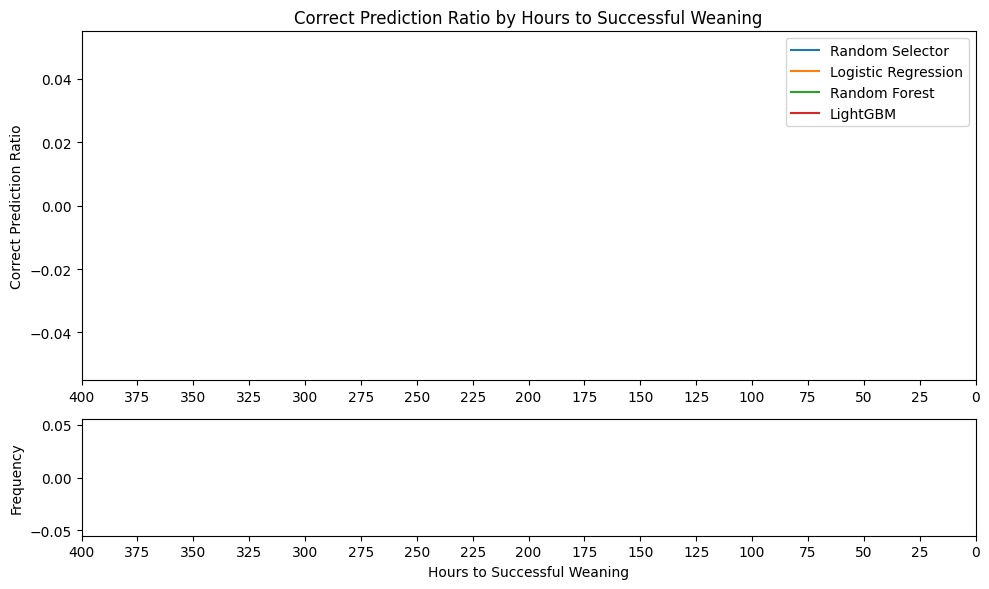

In [148]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Calculate the ratio of correct predictions for each 'hours_to_success_weaning'
ratios = {}
for model_name in models_to_investigate:
    # Group by 'hours_to_success_weaning' and calculate the mean of the correct predictions
    ratios[model_name] = outcome_df.groupby('hours_to_success_weaning')[f'{model_name}_correct'].mean()

# Setup the figure and subplots
fig = plt.figure(figsize=(10, 6))  # Overall figure size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 2 rows, 1 column, with different heights

# Create subplots with different sizes
ax1 = plt.subplot(gs[0])  # This is the first, taller plot
ax2 = plt.subplot(gs[1], sharex=ax1)  # This is the second, shorter plot, sharing the x-axis with ax1

# Plotting the ratios on the first subplot
for model_name in models_to_investigate:
    # Make sure to filter the ratios to only include hours between 0 and 400
    filtered_ratio = ratios[model_name][(ratios[model_name].index >= -50) & (ratios[model_name].index <= 400)]
    ax1.plot(filtered_ratio, label=model_name)

ax1.set_ylabel('Correct Prediction Ratio')
ax1.set_title('Correct Prediction Ratio by Hours to Successful Weaning')
ax1.legend()
ax1.invert_xaxis()  # Ensure the x-axis is inverted for the top plot

# Plotting the histogram on the second subplot
# We are interested in the distribution of sample sizes across 'hours_to_success_weaning' bins
# Make sure to filter the DataFrame to only include hours between 0 and 400
filtered_df = outcome_df[(outcome_df['hours_to_success_weaning'] >= 0) & (outcome_df['hours_to_success_weaning'] <= 400)]
ax2.hist(filtered_df['hours_to_success_weaning'], bins=range(-50, 401, 25), color='gray', alpha=0.7)
ax2.set_xlabel('Hours to Successful Weaning')
ax2.set_ylabel('Frequency')

# Set the x-axis limits and ticks for the shared axis
plt.xlim(0, 400)
plt.xticks(range(0, 401, 25))  # From 0 to 400 with a step of 25
ax2.invert_xaxis()  # Ensure the x-axis is inverted for the top plot

# Show the plot
plt.tight_layout()
plt.show()


In [245]:
print('Overlapping bad cases:', (~outcome_df[[f'{item}_correct' for item in models_to_investigate]]).all(axis=1).sum()/\
      (~outcome_df[[f'{item}_correct' for item in models_to_investigate]]).any(axis=1).sum())

Overlapping bad cases: 0.41118815494499766


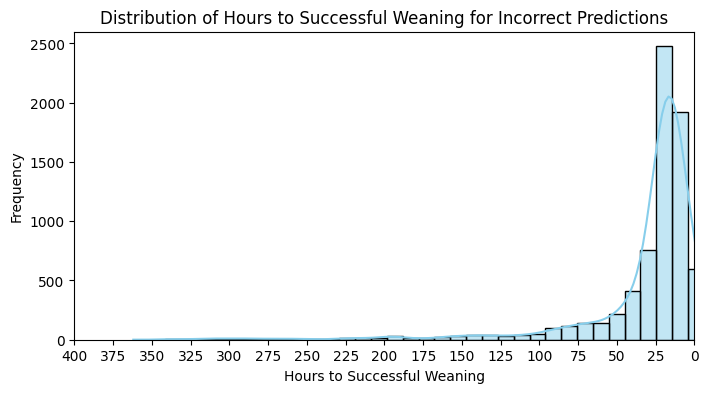

In [246]:
tmp_df = outcome_df[(~outcome_df[[f'{item}_correct' for item in models_to_investigate]]).all(axis=1)]

plt.figure(figsize=(8,4))
# Create a histogram with specified bins
ax = sns.histplot(tmp_df['hours_to_success_weaning'], bins=40, color='skyblue', kde=True)  # KDE for smooth distribution curve

# Setting the x-axis limits to focus on a specific interval
plt.xlim(0, 400)  # Adjusting this based on your data distribution and focus area
plt.xticks(range(0, 401, 25))
# Adding labels and title for clarity
plt.xlabel('Hours to Successful Weaning')
plt.ylabel('Frequency')
plt.title('Distribution of Hours to Successful Weaning for Incorrect Predictions')
ax.invert_xaxis()

# Show plot
plt.show()


In [288]:
outcome_df.loc[(outcome_df[outcome_col[0]]==1)].encounterId.unique()

array(['1250', '15740', '1665', '1698', '23904', '2956', '3514', '5552',
       '832', '8547', 'NIC:1026774:1739288400', 'NIC:104055:1699380600',
       'NIC:1041294:1763999100', 'NIC:1044712:1756060200',
       'NIC:1048877:1788883800', 'NIC:1049670:1760961300',
       'NIC:1060460:1771907700', 'NIC:1065418:1799769600',
       'NIC:1070214:1795360200', 'NIC:1079236:1790906700',
       'NIC:1097814:1813767840', 'NIC:1143086:1852644840',
       'NIC:1153363:1874775360', 'NIC:1163250:1868758200',
       'NIC:1169679:1911643200', 'NIC:1274373:1977078300',
       'NIC:1283642:1983019931', 'NIC:1289699:1979913711',
       'NIC:1290466:1986646556', 'NIC:195631:1677436200',
       'NIC:195631:1679126400', 'NIC:219507:1687375800',
       'NIC:221534:1689184800', 'NIC:231127:1705771800',
       'NIC:246313:1718382780', 'NND:1017188:1727312400',
       'NND:1023597:1733932980', 'NND:111127:1838328300',
       'NND:1208107:1911184800', 'NND:186499:1692518400',
       'NND:191403:1686085200', 'NND

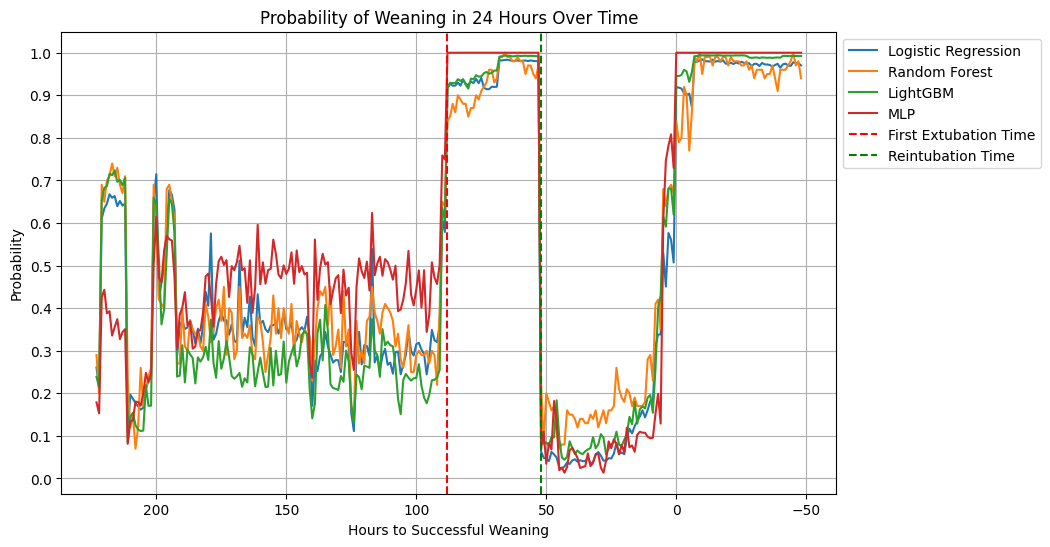

In [302]:
tmp_df = outcome_df.loc[outcome_df.encounterId=='NIC:1097814:1813767840']

reintubation_time = tmp_df.loc[(tmp_df['airwayStatus_Intubated'] == 1) & 
                                                  (tmp_df['timestamp'] > tmp_df.first_extubation_time), 'timestamp']
if not reintubation_time.empty:
    reintubation_time = reintubation_time.iloc[0]
    first_extubation_x = tmp_df.loc[tmp_df.timestamp==tmp_df['first_extubation_time'].iloc[0], 'hours_to_success_weaning'].iloc[0]
    reintubation_x = tmp_df.loc[tmp_df.timestamp==reintubation_time, 'hours_to_success_weaning'].iloc[0]
else:
    first_extubation_x = 0
    reintubation_x = 0
    
plt.figure(figsize=(10, 6))
# Plotting the probabilities over time for each model
for model_name in models_to_investigate:
    # Filtering not applied here as in previous instructions; ensure tmp_df is prepared as needed
    plt.plot(tmp_df['hours_to_success_weaning'], tmp_df[f'{model_name}_proba'], linestyle='-', label=model_name)

# Adding a vertical line for the first_extubation_time
plt.axvline(x=first_extubation_x, color='red', linestyle='--', label='First Extubation Time')

# Adding another vertical line for reintubation_time
plt.axvline(x=reintubation_x, color='green', linestyle='--', label='Reintubation Time')

# Inverting the x-axis
plt.gca().invert_xaxis()
plt.yticks(np.linspace(0, 1, 11)) 
plt.grid(True)

# Adding labels, title, and adjusting the legend position
plt.xlabel('Hours to Successful Weaning')
plt.ylabel('Probability')
plt.title('Probability of Weaning in 24 Hours Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot

# Show plot
plt.show()


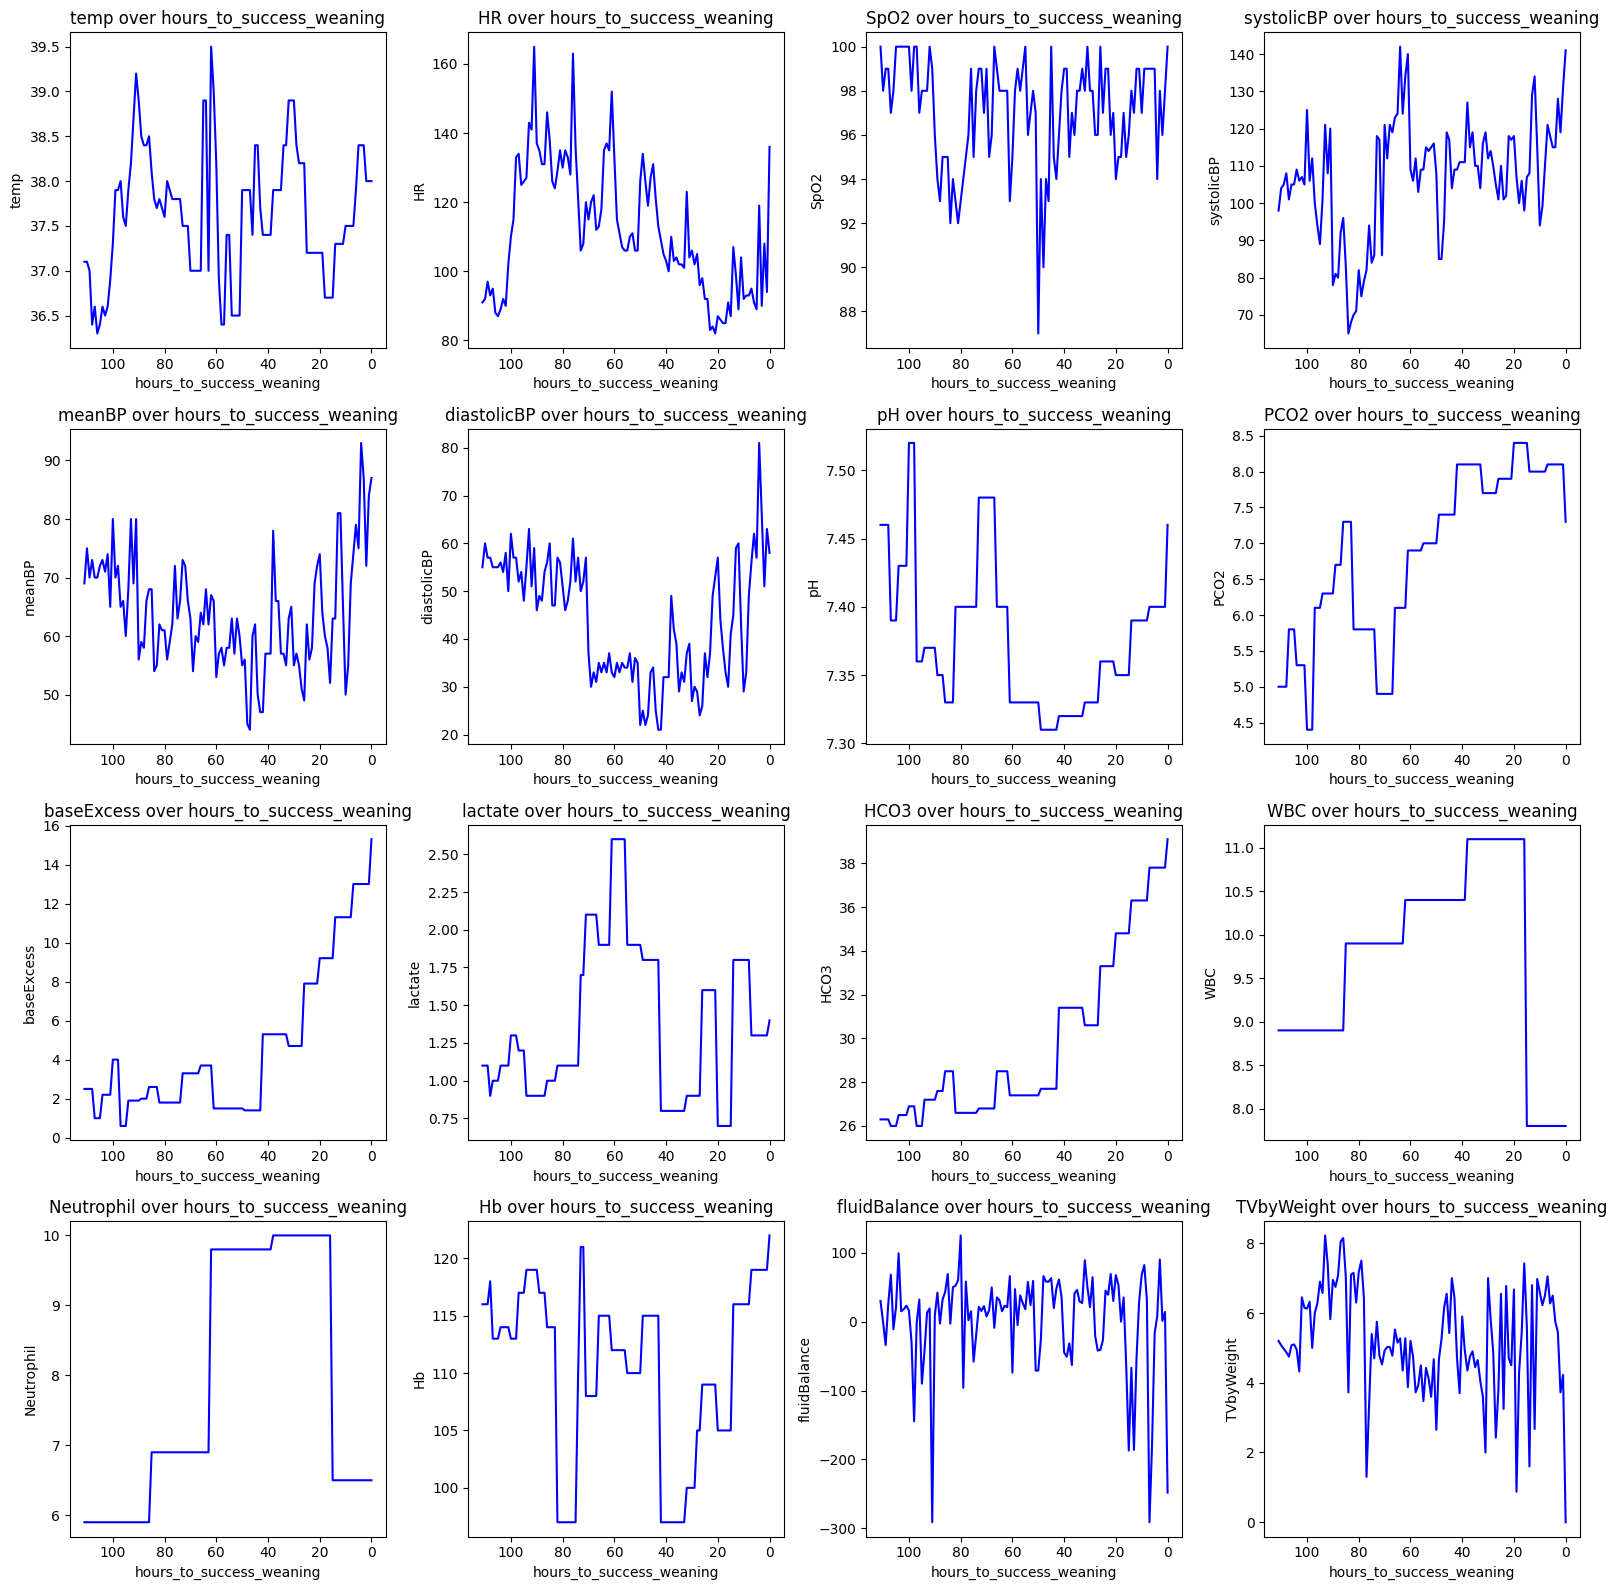

In [42]:

plot_grouped_feature_variation(
    df=tmp_df, 
    group_column=None, 
    numerical_cols=[f'{col}' for col in numerical_obs_cols_tmp],
    categorical_cols=[], 
    hours_col='hours_to_success_weaning'
)

## Model Comparisons and Feature Importance

============================== Logistic Regression ==============================


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


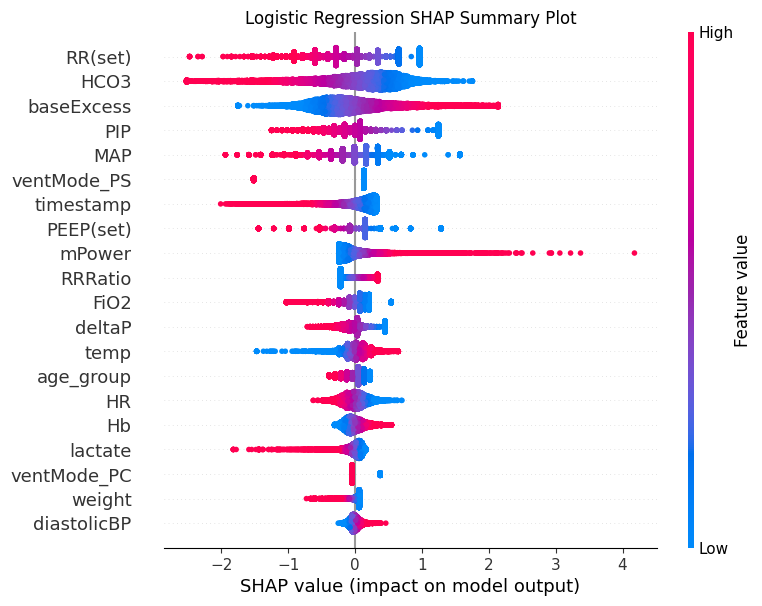

In [20]:

# Names of the models want to plot
# models_to_plot = ['Logistic Regression', 'Random Forest', 'LightGBM']
models_to_plot = ['Logistic Regression']
                  
indices = np.random.choice(len(X_train_selected), int(len(X_train_selected) * 0.1), replace=False)
X_for_SHAP = X_train_selected.iloc[indices]

for name, model in risk_baselines.items():
    if name in models_to_plot:
        print('='*30, name, '='*30)

        # Choose the appropriate explainer based on the model type
        if isinstance(model, (RandomForestClassifier, AdaBoostClassifier, lgb.LGBMClassifier)):
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_for_SHAP)
            # For binary classification, take SHAP values for the positive class
            if isinstance(shap_values, list):
                shap_values = shap_values[1]
        elif isinstance(model, LogisticRegression):
            explainer = shap.LinearExplainer(model, X_for_SHAP, shap.maskers.Independent(X_for_SHAP))
            shap_values = explainer.shap_values(X_for_SHAP)
        else:
            continue

        # Generate summary plot
        shap.summary_plot(shap_values, X_for_SHAP, show=False, plot_size=(8,6))
        plt.title(f"{name} SHAP Summary Plot")
        plt.show()

### LOV Prediction

In [289]:
df_success = df.groupby('encounterId').filter(lambda x: all((x[outcome_col[0]]!=1)&(x[outcome_col[2]]!=1)))
df_success = df_success.groupby('encounterId').apply(lambda x: extract_observational_window(x, window_size=24*28)).reset_index(drop=True)
df_success['hours_to_extubation'] = df_success['first_extubation_time'] - df_success['timestamp']

# Define categories
# df_success['extubation_category'] = pd.cut(df_success['hours_to_extubation'], 
#                                              bins=[-1, 0, 4, 24, 48, float('inf')], 
#                                              labels=['0h', '<4h', '<24h', '<48h', '>48h'])

df_success['extubation_category'] = pd.cut(df_success['hours_to_extubation'], 
                                             bins=[-1, 6, float('inf')], 
                                             labels=['<4h', '>=4h'])

# Group by category and calculate means for categorical columns and median for numerical columns
grouped_comparison = df_success.groupby('extubation_category').agg({**{col: 'mean' for col in categoric_cols},
                                                                     **{col: 'median' for col in numerical_cols}})
grouped_comparison['category_count'] = df_success.groupby('extubation_category').size()

# Move 'category_count' to the second column
cols = grouped_comparison.columns.tolist()
cols.insert(0, cols.pop(cols.index('category_count')))
grouped_comparison = grouped_comparison[cols]

# Display the DataFrame
grouped_comparison.reset_index()

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,extubation_category,category_count,gender,ventMode_PS,age_group,weight,MAP,RR(measured),etCO2,temp,HR,SpO2,systolicBP,meanBP,diastolicBP,pH,PCO2,baseExcess,lactate,HCO3,WBC,Neutrophil,Hb,fluidBalance,TVbyWeight,FiO2,PIP,RR(set),PEEP(set),PS,RRRatio,IERatio,deltaP,mPower,SFRatio,first_extubation_time
0,<4h,20406,0.565716,0.492306,2.0,7.4,7.0,28.0,5.2,37.2,122.0,97.0,88.0,60.0,47.0,7.41,5.9,3.3,1.0,27.2,9.6,5.6,107.0,-0.3,7.230769,25.0,10.0,5.0,5.0,0.0,0.910714,0.06,5.0,0.073500,3.760000,66.0
1,>=4h,281784,0.559936,0.070071,2.0,6.5,9.0,26.0,5.2,37.0,127.0,97.0,82.0,56.0,43.0,7.40,6.1,3.1,1.0,27.2,9.6,5.6,105.0,3.0,7.200000,30.0,18.0,20.0,5.0,0.0,0.142857,0.43,12.0,1.280664,3.166667,134.0


In [544]:
physio_measure = ['age_group', 'weight', 'RR(measured)', 'temp', 'HR', 'SpO2', 'systolicBP',
       'meanBP', 'diastolicBP', 'pH', 'PCO2', 'baseExcess', 'lactate', 'HCO3', 'totalHb', 'WBC',
       'Neutrophil', 'Hb', 'fluidBalance', 'timestamp', 'gender']


df_good_resp = df_success.loc[df_success['extubation_category']=='<4h', numerical_cols+categoric_cols]
df_bad_resp = df_success.loc[df_success['extubation_category']!='<4h', numerical_cols+categoric_cols]

# Convert the results to a DataFrame
comparison_results_df = pd.DataFrame(compute_stat_table(df_good_resp, df_bad_resp, output_only_significant=True))

# Display the comparison results
comparison_results_df

,Column,Test Used,p-Value,Effect Size,Mean/Median_Success,Mean/Median_Failure,Std/IQR_Success,Std/IQR_Failure
0,NMB,Chi-Square,4.914381e-32,NaN,0.002256,0.011588,0.047448,0.107023
1,sedation,Chi-Square,8.060870e-88,NaN,0.148375,0.209146,0.355481,0.406700
2,furosemide,Chi-Square,1.803746e-11,NaN,0.110986,0.127947,0.314123,0.334032
3,ventMode_PC,Chi-Square,0.000000e+00,NaN,0.432286,0.919576,0.495407,0.271948
4,ventMode_PS,Chi-Square,0.000000e+00,NaN,0.567714,0.080424,0.495407,0.271948
5,age_group,Mann-Whitney U,1.882071e-62,0.071665,2.000000,2.000000,3.000000,3.000000
6,weight,Mann-Whitney U,4.140675e-61,0.072068,7.500000,6.500000,10.000000,10.000000
7,MAP,Mann-Whitney U,0.000000e+00,-0.623276,7.000000,9.000000,2.000000,2.000000
8,RR(measured),Mann-Whitney U,3.428154e-25,0.045258,28.000000,27.000000,16.600000,16.600000
9,temp,Mann-Whitney U,0.000000e+00,0.171442,37.200000,37.000000,0.800000,0.800000


In [292]:

# aggregate previous observations
df_baselines = df_success.copy()
df_baselines['extubation_category'] = (df_baselines['extubation_category']=='<4h')
df_baselines['extubation_category'] = df_baselines['extubation_category'].astype(int)

# df_baselines = df_baselines.sample(frac=1, random_state=66).reset_index(drop=True)

# Split the data, retaining 'encounterId'
X_train = df_baselines.loc[df_baselines.encounterId.isin(id_list_train), prediction_features+['IERatio']]
X_test = df_baselines.loc[df_baselines.encounterId.isin(id_list_test), prediction_features+['IERatio']]
y_train = df_baselines.loc[df_baselines.encounterId.isin(id_list_train), 'extubation_category']
y_test = df_baselines.loc[df_baselines.encounterId.isin(id_list_test), 'extubation_category']


# Calculate mean and std for each age group in the training set
age_group_stats = X_train.groupby('age_group')[age_dependent_cols].agg(['mean', 'std'])

for col in age_dependent_cols:
    for age_group in age_group_stats.index:
        # Get mean and std for the age group
        group_mean = age_group_stats.loc[age_group, (col, 'mean')]
        group_std = age_group_stats.loc[age_group, (col, 'std')]

        # Apply transformation for the training set
        X_train.loc[X_train['age_group'] == age_group, col] = (X_train.loc[X_train['age_group'] == age_group, col] - group_mean) / group_std

        # Apply the same transformation to the test set
        X_test.loc[X_test['age_group'] == age_group, col] = (X_test.loc[X_test['age_group'] == age_group, col] - group_mean) / group_std

# Standardization for other numerical columns
scaler = MinMaxScaler()
cols_to_transform = [x for x in numerical_cols_for_pred if x not in age_dependent_cols]
X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])  # Apply same transformation to test data

# Handling Imbalanced Data using Random Oversampling
rus = RandomUnderSampler(sampling_strategy=0.95, random_state=66)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train.values.ravel())

ros = RandomOverSampler(random_state=66)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train.values.ravel())


# X_train_resampled, y_train_resampled = X_train, y_train.values.ravel()

In [ ]:

# using full list of variables
X_train_selected = X_train_resampled
X_test_selected = X_test

_ = train_and_evaluate_models(X_train_selected, y_train_resampled, X_test_selected, y_test, scorer,
                         reweight_class=False, tuning=False, print_detail_results=False, visual=True)


Training Logistic Regression...
Training Random Forest...
Training AdaBoost...
Training MLP...
Training SVM...


In [538]:
df_obs.sort_values(by=['encounterId', 'timestamp'], inplace=True)

df_tmp = df_obs.groupby('encounterId').apply(lambda x: x.iloc[-1]).reset_index(drop=True)
df_test_X = df_tmp.loc[df_tmp.encounterId.isin(id_list_test), numerical_cols+categoric_cols]
df_test_y = df_tmp.loc[df_tmp.encounterId.isin(id_list_test), 'extubation_failure']

df_test_X = scaler.transform(df_test_X)  # Apply same transformation to test data

# 3. Model Evaluation:
print('='*100)
for name, model in trained_baselines.items():
    y_pred = model.predict(df_test_X)
    print(f"Evaluation for {name}:")
    print("Accuracy:", accuracy_score(df_test_y, y_pred))
    print("Precision:", precision_score(df_test_y, y_pred))
    print("Recall:", recall_score(df_test_y, y_pred))
    print("F1-score:", f1_score(df_test_y, y_pred))
    print("ROC-AUC:", roc_auc_score(df_test_y, model.predict_proba(df_test_X)[:, 1]))
    print("Classification Report:\n", classification_report(df_test_y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(df_test_y, y_pred))
    print("-" * 50)


Evaluation for Logistic Regression:
Accuracy: 0.8404384896467723
Precision: 0.18309859154929578
Recall: 0.1511627906976744
F1-score: 0.16560509554140126
ROC-AUC: 0.5160575858250277
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       735
           1       0.18      0.15      0.17        86

    accuracy                           0.84       821
   macro avg       0.54      0.54      0.54       821
weighted avg       0.83      0.84      0.83       821

Confusion Matrix:
 [[677  58]
 [ 73  13]]
--------------------------------------------------
Evaluation for Random Forest:
Accuracy: 0.8440925700365408
Precision: 0.171875
Recall: 0.12790697674418605
F1-score: 0.14666666666666667
ROC-AUC: 0.5312371460211991
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       735
           1       0.17      0.13      0.15        86

    accuracy          

In [63]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# aggregate previous observations
df_baselines = df_success.copy()

# Split the data, retaining 'encounterId'
X_train = df_baselines.loc[df_baselines.encounterId.isin(id_list_train), prediction_features]
X_test = df_baselines.loc[df_baselines.encounterId.isin(id_list_test), prediction_features]
y_train = df_baselines.loc[df_baselines.encounterId.isin(id_list_train), 'hours_to_extubation']
y_test = df_baselines.loc[df_baselines.encounterId.isin(id_list_test), 'hours_to_extubation']


# Calculate mean and std for each age group in the training set
age_group_stats = X_train.groupby('age_group')[age_dependent_cols].agg(['mean', 'std'])

for col in age_dependent_cols:
    for age_group in age_group_stats.index:
        # Get mean and std for the age group
        group_mean = age_group_stats.loc[age_group, (col, 'mean')]
        group_std = age_group_stats.loc[age_group, (col, 'std')]

        # Apply transformation for the training set
        X_train.loc[X_train['age_group'] == age_group, col] = (X_train.loc[X_train['age_group'] == age_group, col] - group_mean) / group_std

        # Apply the same transformation to the test set
        X_test.loc[X_test['age_group'] == age_group, col] = (X_test.loc[X_test['age_group'] == age_group, col] - group_mean) / group_std

# Standardization for other numerical columns
scaler = MinMaxScaler()
cols_to_transform = [x for x in numerical_cols_for_pred if x not in age_dependent_cols]
X_train[cols_to_transform] = scaler.fit_transform(X_train[cols_to_transform])
X_test[cols_to_transform] = scaler.transform(X_test[cols_to_transform])  # Apply same transformation to test data

# Sample the indices
sample_indices = np.random.choice(len(X_train), size=int(len(X_train)*1), replace=False)

# Create the sampled datasets
X_train_resampled = X_train.iloc[sample_indices]
y_train_resampled = y_train.iloc[sample_indices]

# Log transformation of the target variable
y_train_log = np.log1p(y_train_resampled)
y_test_log = np.log1p(y_test)


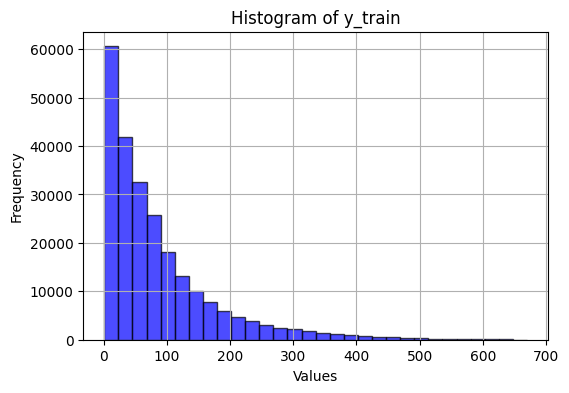

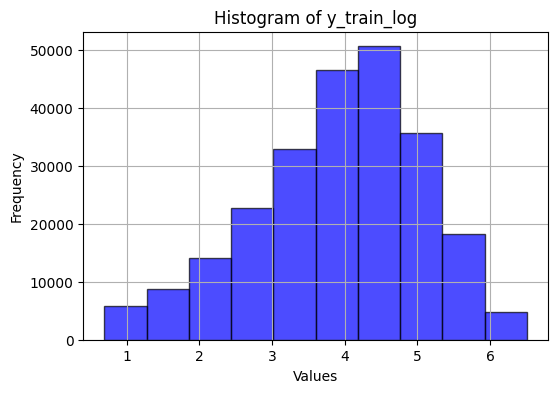

In [365]:

# Histogram
plt.figure(figsize=(6,4))
plt.hist(y_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of y_train')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Density Plot
plt.figure(figsize=(6,4))
plt.hist(y_train_log, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of y_train_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [364]:
import statsmodels.api as sm

# Adding a constant to the model (for the intercept)
X = sm.add_constant(X_train_resampled[[x for x in X_train.columns if x not in [ 'ventMode_PC']]])

# Fit the OLS model
model = sm.OLS(y_train_log, X).fit()

# Get the summary
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     hours_to_extubation   R-squared:                       0.348
Model:                             OLS   Adj. R-squared:                  0.348
Method:                  Least Squares   F-statistic:                     3672.
Date:                 Thu, 15 Feb 2024   Prob (F-statistic):               0.00
Time:                         21:14:43   Log-Likelihood:            -3.2706e+05
No. Observations:               240591   AIC:                         6.542e+05
Df Residuals:                   240555   BIC:                         6.546e+05
Df Model:                           35                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1828      0.052    

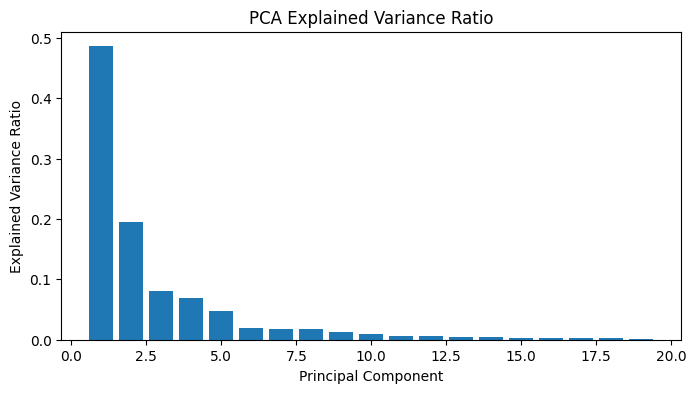

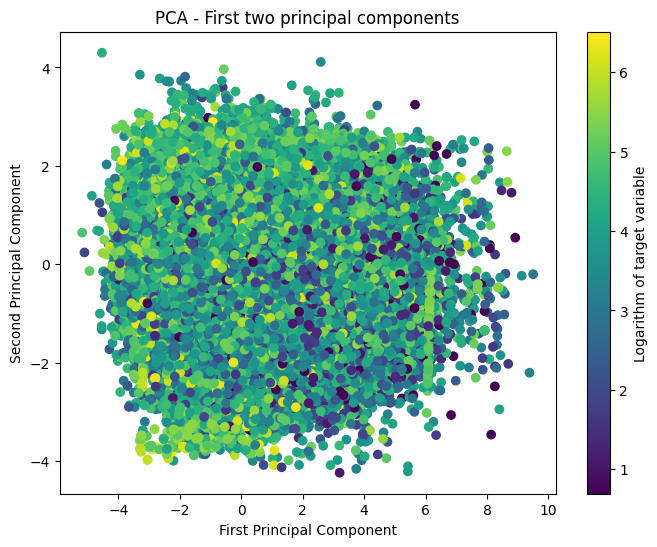

In [368]:
from sklearn.decomposition import PCA
# Assuming PCA has been applied to X_train_selected
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('PCA Explained Variance Ratio')
plt.show()

# Scatter plot for first two principal components (if applicable)
if X_train_pca.shape[1] >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_log, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.colorbar(label='Logarithm of target variable')
    plt.title('PCA - First two principal components')
    plt.show()

In [370]:


# # Feature Selection using RFE with cross-validation:
# print('='*100)
# selector = RFECV(estimator=LinearRegression(), step=1, cv=5)
# selector = selector.fit(X_train_resampled, y_train_log)
# selected_features = X_train_resampled.columns[selector.support_]
# print(f'Total of {len(selected_features)} features has been selected:\n', selected_features)

# # Use only selected features for training and testing
# X_train_selected = X_train_resampled[selected_features]
# X_test_selected = X_test[selected_features]

# Initialize PCA
pca = PCA(n_components=0.99)  # Retain 95% of the variance

# Apply PCA on your training data
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)

X_train_pca = X_train_resampled
X_test_pca = X_test

# Define the parameter grids
ridge_params = {'alpha': np.logspace(-4, 4, 10)}
lasso_params = {'alpha': np.logspace(-4, 4, 10)}
rf_params = {'n_estimators': [100, 200],'max_depth': [10, 20, None]}
gbr_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5]}
svr_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}

# Define your models with hyperparameter grids
# models = {
#     "Linear Regression": (LinearRegression(), None),
#     "Ridge Regression": (Ridge(), ridge_params),
#     "Lasso Regression": (Lasso(), lasso_params),
#     "Random Forest": (RandomForestRegressor(), rf_params),
#     "Gradient Boosting Regressor": (GradientBoostingRegressor(), gbr_params),
#     "Support Vector Regressor": (SVR(), svr_params)
# }

# Define your models with hyperparameter grids
models = {
    "Linear Regression": (LinearRegression(), None),
    "Ridge Regression": (Ridge(), None),
    "Lasso Regression": (Lasso(), None),
    "Random Forest": (RandomForestRegressor(), None),
    "Gradient Boosting Regressor": (GradientBoostingRegressor(), None),
    "Support Vector Regressor": (SVR(), None)
}

# Train each model using GridSearchCV
trained_baselines = {}
print('=' * 100)
for name, (model, params) in models.items():
    print(f"Training {name} with hyperparameter tuning...")
    if params:
        grid_search = GridSearchCV(model, params, cv=2, n_jobs=16, verbose=1)
        grid_search.fit(X_train_pca, y_train_log)
        best_model = grid_search.best_estimator_
        print(f"Best params for {name}: ", grid_search.best_params_)
    else:
        best_model = model.fit(X_train_pca, y_train_log)
    trained_baselines[name] = best_model
    print(f"Best score for {name}: ", best_model.score(X_train_pca, y_train_log))
    print("-" * 50)

# Evaluate models
print('=' * 100)
for name, model in trained_baselines.items():
    print(f"Evaluating {name}...")

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Evaluate predictions
    mae = mean_absolute_error(y_test_log, y_pred)
    mse = mean_squared_error(y_test_log, y_pred)
    r2 = r2_score(y_test_log, y_pred)

    print(f"Results for {name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  Mean Squared Error (MSE): {mse:.2f}")
    print(f"  R-squared (R2): {r2:.2f}")
    print("=" * 50)


Training Linear Regression with hyperparameter tuning...
Best score for Linear Regression:  0.34819550819152756
--------------------------------------------------
Training Ridge Regression with hyperparameter tuning...
Best score for Ridge Regression:  0.3481897017525063
--------------------------------------------------
Training Lasso Regression with hyperparameter tuning...
Best score for Lasso Regression:  0.0
--------------------------------------------------
Training Random Forest with hyperparameter tuning...
Best score for Random Forest:  0.9814296071036716
--------------------------------------------------
Training Gradient Boosting Regressor with hyperparameter tuning...
Best score for Gradient Boosting Regressor:  0.42426343621974005
--------------------------------------------------
Training Support Vector Regressor with hyperparameter tuning...
Best score for Support Vector Regressor:  0.4708673393841245
--------------------------------------------------
Evaluating Linear R

In [125]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Convert the pandas DataFrame to a numpy array first
X_train_numpy = X_train_resampled[cols].to_numpy().astype(np.float32)
y_train_numpy = y_train_log.to_numpy().astype(np.float32).reshape(-1, 1)  # assuming y_train_log is a Series
X_test_numpy = X_test[cols].to_numpy().astype(np.float32)
y_test_numpy = y_test_log.to_numpy().astype(np.float32).reshape(-1, 1)

# Now convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_numpy)
y_train_tensor = torch.from_numpy(y_train_numpy)
X_test_tensor = torch.from_numpy(X_test_numpy)
y_test_tensor = torch.from_numpy(y_test_numpy)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 1)
#         )
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),  # Increased from 64 to 128
            nn.ReLU(),
#             nn.BatchNorm1d(128),  # Batch normalization layer after first ReLU
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout layer for regularization
            nn.Linear(64, 64),  # Another layer with 64 neurons
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.layers(x)


# Parameters for regularization and optimization
weight_decay = 1e-5  # This is a typical value for weight decay, adjust as necessary
initial_lr = 1e-3    # Initial learning rate
    
model = MLP(input_size=X_train_numpy.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()

# Optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Scheduler to reduce learning rate on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Train the model
model.train()
for epoch in range(10):
    total_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Average Loss: {average_loss}')
    
    # Step the scheduler on each epoch
    scheduler.step(average_loss)


# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device)).cpu()
    mae = mean_absolute_error(y_test_log, predictions.numpy())
    mse = mean_squared_error(y_test_log, predictions.numpy())
    r2 = r2_score(y_test_log, predictions.numpy())

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Epoch 1, Average Loss: 1.146905358850901
Epoch 2, Average Loss: 0.9782664607199587
Epoch 3, Average Loss: 0.9507901233280399
Epoch 4, Average Loss: 0.9261757745925739
Epoch 5, Average Loss: 0.9093770237245286
Epoch 6, Average Loss: 0.8966510866423221
Epoch 7, Average Loss: 0.884010601949792
Epoch 8, Average Loss: 0.8734721950985977
Epoch 9, Average Loss: 0.8678270015582166
Epoch 10, Average Loss: 0.8586169631287579
Mean Absolute Error: 0.7854693567965385
Mean Squared Error: 1.04200782903291
R-squared: 0.27867253170727857


### Considering time-dependencies, but not learning the episode as a whole

In [467]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

# Assuming df is your DataFrame and it's already sorted by encounterId and timestamp

def create_lov_sequences(df, selected_features, context_len=1000, largest_lov=24*28, window_size=8, noise_level=0.):
    sequences = []
    labels = []  
    for encounter_id, group in df.groupby('encounterId'):
        encounter_data = group.reset_index(drop=True)  # Reset index if not already sequential
        for i in range(1, len(encounter_data)+1, window_size):
            start_idx = max(0, i - context_len)
            seq = encounter_data.iloc[start_idx:i]
            label = int(seq['LOV_left'].iloc[-1])
            if (label >= 0) & (label<=largest_lov):
                seq = seq[selected_features]
                noise = np.random.normal(0, noise_level, seq.shape)
                noisy_seq = seq.values + noise
                sequences.append(noisy_seq)
                labels.append(label)
                
    return sequences, labels

sequences_train, labels_train = create_lov_sequences(df_train, prediction_features, \
                                                     context_len=24, largest_lov=240, window_size=4, noise_level=0.01)
sequences_test, labels_test = create_lov_sequences(df_test, prediction_features, \
                                                   context_len=24, largest_lov=240, window_size=4, noise_level=0.01)


In [470]:
def transform_labels_to_numeric_categories(labels, thresholds=[12]):

    def single_label_to_numeric_category(label):
        """Helper function to convert a single label into a numeric category."""
        for i, threshold in enumerate(thresholds):
            if label < threshold:
                return i
        return len(thresholds)
    
    # Handle single numerical value
    if isinstance(labels, (int, float)):
        return single_label_to_numeric_category(labels)
    
    # Handle iterable of labels
    transformed_labels = [single_label_to_numeric_category(label) for label in labels]
    
    return transformed_labels

In [471]:
# convert into Tensors
def sequences_to_tensor(sequences):
    tensor_seqs = [torch.tensor(s, dtype=torch.float) for s in sequences]
    return pad_sequence(tensor_seqs, batch_first=True, padding_value=-1)

X_train_tensor = sequences_to_tensor(sequences_train)
X_test_tensor = sequences_to_tensor(sequences_test)

# y_train_tensor = torch.tensor(np.log1p(labels_train), dtype=torch.float).unsqueeze(-1)
# y_test_tensor = torch.tensor(np.log1p(labels_test), dtype=torch.float).unsqueeze(-1)

# y_train_tensor = torch.tensor(labels_train, dtype=torch.long).unsqueeze(-1)
# y_test_tensor = torch.tensor(labels_test, dtype=torch.long).unsqueeze(-1)

y_train_tensor = torch.tensor(transform_labels_to_numeric_categories(labels_train), dtype=torch.long)
y_test_tensor = torch.tensor(transform_labels_to_numeric_categories(labels_test), dtype=torch.long)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from itertools import product
from torch.optim.lr_scheduler import StepLR

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

def train_model(model, train_loader, num_epochs, optimizer, criterion, scheduler=None, \
                val_loader=None, eval_fn=None, patience=5, device='cpu', silent_mode=True):
    # Check if the model is already on the desired device
    if next(model.parameters()).device != device: model.to(device)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0
        
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1

        if scheduler is not None: scheduler.step()
                    
        if not silent_mode: print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {(total_loss / num_batches):.4f}')
        
        if val_loader is not None:
            # Validation phase
            val_loss = evaluate_model(model, val_loader, eval_fn, device)
            if not silent_mode: print(f'Validation Loss: {(val_loss):.4f}')
            
            # Check for early stopping, this need to be changed, should be < for really loss
            if val_loss > best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
    #                 print("Early stopping triggered")
                    early_stop = True
                    break  # Exit the training loop
    
    return epoch+1

def evaluate_model(model, data_loader, eval_fn, device='cpu'):
    if next(model.parameters()).device != device: model.to(device)
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            
            # For classification
            _, predicted = torch.max(outputs, 1)
                    
            predictions.extend(predicted.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
            
    return eval_fn(targets, predictions)


def cross_validate_lstm(X, y, params_grid, num_epochs, num_folds=5, device='cpu', silent_mode=True):
    kf = KFold(n_splits=num_folds)
    input_dim = X.shape[-1]
    scores = []

    for hidden_dim, num_layers, dropout, lr, batch_size, weight_decay in params_grid:
        fold_scores = []
        for train_index, val_index in kf.split(X.numpy()):  # Assuming X is a tensor
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]

            # DataLoader for training and validation set
            train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), batch_size=batch_size)

            # Initialize model, loss, and optimizer
            model = LSTMModel(input_dim, hidden_dim, num_layers, dropout, 2)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = StepLR(optimizer, step_size=5, gamma=0.9)  # Decay LR every 5 epochs
            
            
            classes, counts = np.unique(y_train_fold.numpy(), return_counts=True)
            class_weights = 1. / torch.tensor(counts, dtype=torch.float) 
            class_weights = (class_weights / class_weights.min()).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights)


            criterion = nn.CrossEntropyLoss()
#             criterion = nn.MSELoss()  # Change to regression loss
            total_epoch = train_model(model, train_loader, num_epochs, optimizer, criterion, scheduler, None, \
                        average_precision_score, device=device, silent_mode=silent_mode)
            val_result = evaluate_model(model, val_loader, average_precision_score, device)
            fold_scores.append(val_result)
                    
        average_eval = np.mean(fold_scores)
        scores.append((hidden_dim, num_layers, dropout, lr, batch_size, weight_decay, total_epoch, average_eval))
        print(20*'*', scores[-1], 20*'*')
        
    return scores


In [511]:
import random

# Hyperparameter search
hidden_dims = [16, 32, 64, 128]
num_layers_options = [2, 3]
dropout_rates = [0.1, 0.25, 0.5]
learning_rates = [0.001, 0.0001]
batch_sizes = [16, 32, 64, 128]
weight_decays = [1e-4, 1e-5]
num_epochs = 10

# params_grid = [(hidden_dim, num_layers, dropout, lr, batch_size, weight_decay) 
#                for hidden_dim, num_layers, dropout, lr, batch_size, weight_decay in product(hidden_dims, num_layers_options, \
#                                                                   dropout_rates, learning_rates, batch_sizes, weight_decays) 
#                if not (num_layers == 1 and dropout > 0)]

all_params = list(product(hidden_dims, num_layers_options, dropout_rates, learning_rates, batch_sizes, weight_decays))
num_samples = 10 
params_grid = random.sample(all_params, num_samples)

# Run cross-validation
def random_sample_tensors(X, y, sample_size):
    indices = np.random.choice(np.arange(len(X)), size=sample_size, replace=False)
    X_sampled = X[indices]
    y_sampled = y[indices]
    return X_sampled, y_sampled

sample_size = int(len(X_train_tensor)*1)
X_train_sampled, y_train_sampled = random_sample_tensors(X_train_tensor, y_train_tensor, sample_size)

cv_results = cross_validate_lstm(X_train_sampled, y_train_sampled, params_grid, num_epochs, num_folds=3, \
                                 device='cuda', silent_mode=True)

# Find the best parameters
best_params = max(cv_results, key=lambda x: x[-1])
print("Best parameters:", best_params)

******************** (64, 3, 0.5, 0.0001, 32, 0.0001, 5, 0.8703744388429872) ********************
******************** (64, 3, 0.25, 0.0001, 16, 0.0001, 5, 0.8815714705406767) ********************
******************** (32, 2, 0.1, 0.001, 16, 1e-05, 5, 0.8817671911437986) ********************
******************** (128, 2, 0.1, 0.001, 16, 0.0001, 5, 0.8854532622168186) ********************
******************** (16, 3, 0.5, 0.0001, 16, 0.0001, 5, 0.8633760237035464) ********************
******************** (128, 3, 0.25, 0.001, 32, 0.0001, 5, 0.8882848538428053) ********************
******************** (64, 3, 0.25, 0.0001, 64, 1e-05, 5, 0.8680981484972804) ********************
******************** (16, 3, 0.1, 0.001, 128, 0.0001, 5, 0.8838219355236872) ********************
******************** (16, 3, 0.1, 0.001, 32, 0.0001, 5, 0.8857793345850747) ********************
******************** (64, 2, 0.1, 0.001, 32, 0.0001, 5, 0.893892932300135) ********************
Best parameters: (64, 2

In [512]:
num_epochs = 100

# Extract the best parameters
best_hidden_dim, best_num_layers, best_dropout, best_lr, best_batch_size, best_weight_decay, num_epochs, _ = best_params

# best_hidden_dim, best_num_layers, best_dropout, best_lr, best_batch_size, best_weight_decay, num_epochs = [64, 4, 0.1, 1e-04, 64, 1e-05, 100]

# Initialize the best model
best_model = LSTMModel(X_train_tensor.shape[-1], best_hidden_dim, best_num_layers, best_dropout, output_dim=2)




# Assuming y_train_tensor is your training labels tensor
classes, counts = np.unique(y_train_tensor.numpy(), return_counts=True)
class_weights = 1. / torch.tensor(counts, dtype=torch.float) 
class_weights = (class_weights / class_weights.min()).to('cuda')
criterion = nn.CrossEntropyLoss(weight=class_weights)



optimizer = optim.Adam(best_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)  # Decay LR every 5 epochs

# Create a DataLoader for the entire training dataset
full_train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=best_batch_size, shuffle=False)

# Train the model
_ = train_model(best_model, full_train_loader, num_epochs, optimizer, criterion, scheduler, test_loader, \
                        average_precision_score, device='cuda', silent_mode=False)

# Evaluate the model
test_score = evaluate_model(best_model, test_loader, average_precision_score, device='cuda')
print(f"Test score: {test_score}")


Epoch 1/5, Training Loss: 0.5225
Validation Loss: 0.9109
Epoch 2/5, Training Loss: 0.4806
Validation Loss: 0.9156
Epoch 3/5, Training Loss: 0.4733
Validation Loss: 0.9190
Epoch 4/5, Training Loss: 0.4680
Validation Loss: 0.9182
Epoch 5/5, Training Loss: 0.4648
Validation Loss: 0.9199
Test score: 0.919927182360746


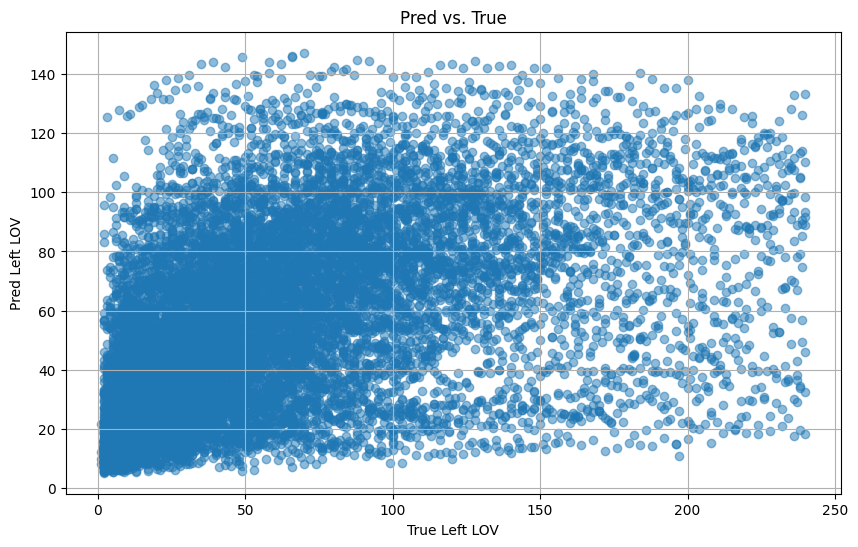

In [263]:
## Sanity check
best_model.eval()  # Ensure the model is in evaluation mode
device = torch.device('cpu')  # Assuming you've moved your model back to CPU
best_model.to(device)

with torch.no_grad():
    predictions = best_model(X_test_tensor.to(device))  # Make predictions

# Convert predictions and labels back to the original scale if they were transformed (e.g., using log1p)
predictions= torch.expm1(predictions.squeeze())
labels = torch.expm1(y_test_tensor.squeeze())
# labels = y_test_tensor

# Calculate the absolute errors
absolute_errors = torch.abs(predictions - labels)

plt.figure(figsize=(10, 6))
plt.scatter(labels.numpy(), predictions.numpy(), alpha=0.5)
plt.title('Pred vs. True')
plt.xlabel('True Left LOV')
plt.ylabel('Pred Left LOV')
plt.grid(True)
plt.show()

In [501]:
## Sanity check
best_model.eval()  # Ensure the model is in evaluation mode
device = torch.device('cpu')  # Assuming you've moved your model back to CPU
best_model.to(device)

with torch.no_grad():
    predictions = best_model(X_test_tensor.to(device))  # Make predictions

# Assuming predictions are logits; convert to class labels
_, predicted_labels = torch.max(predictions, 1)

# Assuming y_test_tensor contains the true class labels
true_labels = y_test_tensor

# Calculate the confusion matrix
cm = confusion_matrix(true_labels.numpy(), predicted_labels.cpu().numpy())

print(cm)


[[1747  411]
 [3522 7682]]


### seq2seq

In [428]:
def create_lov_seq2seq(df, selected_features, context_len=24, largest_lov=24*28, noise_level=0.):
    sequences = []
    targets = []  
    for encounter_id, group in df.groupby('encounterId'):
        encounter_data = group.reset_index(drop=True)
        for i in range(context_len, len(encounter_data) + 1):
            seq = encounter_data.iloc[i-context_len:i]
            # Calculate remaining time at each step within the window
            remaining_times = seq['LOV_left']
            if all(0 <= remaining_times) & all(remaining_times <= largest_lov):
                seq_features = seq[selected_features]
                noise = np.random.normal(0, noise_level, seq_features.shape)
                noisy_seq = seq_features + noise
                sequences.append(noisy_seq.values)
                targets.append(remaining_times.values)
                
    return sequences, targets

# Convert sequences and targets into tensors and ensure they're the correct shape for LSTM
def sequences_to_tensor(sequences, targets):
    # Padding sequences to ensure uniform length
    sequence_tensors = [torch.tensor(s, dtype=torch.float32) for s in sequences]
    target_tensors = [torch.tensor(t, dtype=torch.float32) for t in targets]
    
    # Using pad_sequence to handle varying lengths - you might choose to pad or truncate to a fixed length instead
    padded_sequences = pad_sequence(sequence_tensors, batch_first=True, padding_value=0)
    padded_targets = pad_sequence(target_tensors, batch_first=True, padding_value=-1)  # Use an appropriate padding value for targets
    
    return padded_sequences, padded_targets

# Example usage with your dataset
sequences_train, targets_train = create_lov_seq2seq(df_train, prediction_features, context_len=100, largest_lov=24*28)
sequences_test, targets_test = create_lov_seq2seq(df_test, prediction_features, context_len=100, largest_lov=24*28)

X_train_tensor, y_train_tensor = sequences_to_tensor(sequences_train, targets_train)
X_test_tensor, y_test_tensor = sequences_to_tensor(sequences_test, targets_test)


In [431]:

def create_lov_seq2seq_with_random_gaps(df, selected_features, context_len=24, largest_lov=24*28, noise_level=0., gap_chance=0.3):
    sequences = []
    targets = []
    
    for encounter_id, group in df.groupby('encounterId'):
        encounter_data = group.reset_index(drop=True)  # Reset index if not already sequential
        for i in range(1, len(encounter_data)+1):
            start_idx = max(0, i - context_len)
            seq = encounter_data.iloc[start_idx:i]
            label = seq['LOV_left'].astype(int)
            if all(0 <= label) & all(label <= largest_lov):
                seq_features = seq[selected_features]
                noise = np.random.normal(0, noise_level, seq_features.shape)
                noisy_seq = seq_features + noise
                # Select subsequence based on random indices
                indices = sorted(random.sample(range(len(seq)), int(len(seq) * (1 - gap_chance))))
                seq_features.iloc[indices] = 0
                label.iloc[indices] = -1
                sequences.append(noisy_seq.values)
                targets.append(label.values)
                
    return sequences, targets
                
    

In [432]:
# Example usage with your dataset
sequences_train, targets_train = create_lov_seq2seq_with_random_gaps(df_train, prediction_features, context_len=100, largest_lov=24*28, noise_level=0.0, gap_chance=0.3)

X_train_tensor, y_train_tensor = sequences_to_tensor(sequences_train, targets_train)


In [434]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        
    def forward(self, src):
        outputs, (hidden, cell) = self.lstm(src)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1, dropout=0.0):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        output, (hidden, cell) = self.lstm(input.unsqueeze(1), (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src, trg = src.to(self.device), trg.to(self.device)  # Ensure src and trg are on the correct device
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = torch.full((batch_size, 1), 24*28, device=self.device, dtype=torch.float32)

        for t in range(0, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = trg[:, t].unsqueeze(1) if teacher_force else output
            
        return outputs

In [436]:
def train(model, train_loader, optimizer, criterion, clip, device='cpu'):
    model.train()
    epoch_loss = 0
    
    for src, trg in train_loader:
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model(src, trg)  
        output_dim = output.shape[-1]
        # Assuming the output is [batch_size, trg_len, output_dim] and trg is [batch_size, trg_len]
        output = output.view(-1, output_dim)  # Flatten output for loss calculation if necessary
        trg = trg.view(-1, output_dim)  # Flatten target if necessary, ensure dimensions align with output        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_loader)

# Example training call
N_EPOCHS = 10
CLIP = 1
input_dim = len(prediction_features)  # e.g., number of features in your dataset
output_dim = 1  # Since predicting remaining time is a regression task
hidden_dim = 256  # Example size, adjust based on performance
enc_layers = 2  # Number of encoder layers
dec_layers = 2  # Number of decoder layers
dropout = 0.5  # Dropout rate to prevent overfitting

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize Encoder and Decoder
encoder = Encoder(input_dim, hidden_dim, enc_layers, dropout)
decoder = Decoder(output_dim, hidden_dim, dec_layers, dropout)

# Initialize Seq2Seq model
model = Seq2Seq(encoder, decoder, device='cuda').to('cuda')
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP, device='cuda')
    
    # Example evaluation call
    mae_criterion = torch.nn.L1Loss()
    test_loss = evaluate(model, test_loader, mae_criterion, device='cuda')

    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')
    print(f'Validation Loss: {test_loss:.3f}')


Epoch: 01, Train Loss: 3418.374
Validation Loss: 83.437
Epoch: 02, Train Loss: 3323.330
Validation Loss: 80.887
Epoch: 03, Train Loss: 3318.629
Validation Loss: 86.768


KeyboardInterrupt: 

In [392]:
def evaluate(model, test_loader, criterion, device='cpu'):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0)  # Turn off teacher forcing
            output_dim = output.shape[-1]
            # Assuming the output is [batch_size, trg_len, output_dim] and trg is [batch_size, trg_len]
            output = output[:, -1].view(-1, output_dim)  # Flatten output for loss calculation if necessary
            trg = trg[:, -1].view(-1, output_dim)  # Flatten target if necessary, ensure dimensions align with output
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(test_loader)

# Example evaluation call
mae_criterion = torch.nn.L1Loss()
test_loss = evaluate(model, test_loader, mae_criterion, device='cuda')
print(f'Validation Loss: {test_loss:.3f}')


Validation Loss: 73.762


## Draft

In [55]:
import os

data_dir = '/home/el2522/Documents/DS217/users/el2522/StageNet/data/'  # Define the data directory

df_tmp = df.copy()
# Determine y_true based on the rules provided
df_tmp['y_true'] = (df_tmp['extubation_ready']).astype(int)
df_tmp = df_tmp.rename(columns={'timestamp': 'Hours'})


# Split the DataFrame based on unique encounters
unique_encounters = df_tmp['encounterId'].unique()
train_val_encounters, test_encounters = train_test_split(unique_encounters, test_size=0.20, random_state=66)
train_encounters, val_encounters = train_test_split(train_val_encounters, test_size=0.20, random_state=66)  # Adjusting for correct proportion

# Filter the original DataFrame to create train, val, test subsets
train_df = df_tmp[df_tmp['encounterId'].isin(train_encounters)]
val_df = df_tmp[df_tmp['encounterId'].isin(val_encounters)]
test_df = df_tmp[df_tmp['encounterId'].isin(test_encounters)]

def create_timeseries_csvs_and_listfile(sub_df, dataset_type):
    assert dataset_type in ['train', 'val', 'test']
    listfile_rows = []

    for encounterId, group in sub_df.groupby('encounterId'):  # Ensure referencing df_tmp
        # Create the timeseries CSV
        filename = f"{encounterId}_timeseries.csv"
        cols_to_save = list(set(['Hours'] + [col for col in prediction_features if col not in ['timestamp']]))
        timeseries_df = group[cols_to_save].sort_values('Hours')
        filepath = os.path.join(data_dir, dataset_type, filename)  # Adjust file path
        os.makedirs(os.path.dirname(filepath), exist_ok=True)  # Ensure directory exists
        timeseries_df.to_csv(filepath, index=False)

        # Assuming period_length is derived from the 'timestamp'
        period_length = len(timeseries_df)
        y_true = group['y_true'].iloc[0]
        listfile_rows.append([filename, period_length, y_true])

    # Create listfile DataFrame and save it
    listfile_df = pd.DataFrame(listfile_rows, columns=['stay', 'period_length', 'y_true'])
    listfile_df.to_csv(os.path.join(data_dir, f"{dataset_type}_listfile.csv"), index=False)  # Adjust file path

# Generate CSVs and listfiles for each dataset type
create_timeseries_csvs_and_listfile(train_df, 'train')
create_timeseries_csvs_and_listfile(val_df, 'val')
create_timeseries_csvs_and_listfile(test_df, 'test')
